### Code

In [9]:
import os
import json
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

In [1]:
def class_distribution(org_df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    df = copy.deepcopy(org_df)
    df['mean'] = df['mean'].apply(np.round)
    for idx, label_type in enumerate(['clean_label', 'noisy_label', 'mean']):
        value_counts = df[label_type].value_counts().sort_index()
        bars = axs[idx].bar(value_counts.index, value_counts.values)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axs[idx].text(bar.get_x() + bar.get_width()/2, height, str(height), 
                          ha='center', va='bottom', fontsize=10, color='black')
        
        axs[idx].set_title(label_type)
        axs[idx].set_xticks(value_counts.index)
    
    plt.suptitle('Class Distribution')
    plt.show()

In [2]:
def corruption_plot(df):

    clean_df = df[df['noisy_label'] == df['clean_label']]
    corrupted_df = clean_df[clean_df['mean'].round().astype(int) != clean_df['noisy_label']]
    # Data for the plot
    categories = clean_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(clean_df[clean_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrupted_df[corrupted_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    corruption_ratio = np.mean(np.where(values1 != 0, np.array(values2) / np.array(values1), 0))

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='green', label='Clean Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='red', label='Corrupted Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Clean Labels = {len(clean_df)}, Total Corrupted Labels = {len(corrupted_df)}, Corruption Ratio = {corruption_ratio:.4f}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [3]:
def correction_plot(df):
    noisy_df = df[df['noisy_label'] != df['clean_label']]
    corrected_df = noisy_df[noisy_df['mean'].round().astype(int) == noisy_df['clean_label']]
    # Data for the plot
    categories = noisy_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(noisy_df[noisy_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrected_df[corrected_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    correction_ratio = np.mean(np.where(values1 != 0, np.array(values2) / np.array(values1), 0))

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='orange', label='Noisy Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='blue', label='Corrected Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Noisy Labels = {len(noisy_df)}, Total Corrected Labels = {len(corrected_df)}, Correction Ratio = {correction_ratio:.4f}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [4]:
def sigma_plot(df): 
    # Sigma Analysis
    sigma_clean = df[df['mean'].round() == df['clean_label']]['sigma']
    sigma_noisy = df[df['mean'].round() != df['clean_label']]['sigma']

    # Set fixed number of bins
    num_bins = 20
    min_val = min(sigma_clean.min(), sigma_noisy.min())
    max_val = max(sigma_clean.max(), sigma_noisy.max())
    bins = np.linspace(min_val, max_val, num_bins + 1)  # Bin edges
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Bin centers for labels

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    for ax, sigma_data, color, title in zip(
        axes, [sigma_clean, sigma_noisy], ['green', 'red'],
        ['Sigma Distribution (Clean Data)', 'Sigma Distribution (Noisy Data)']):

        # Create histogram using fixed bins
        counts, _, patches = ax.hist(sigma_data, bins=bins, color=color, alpha=0.8, edgecolor='black')

        ax.set_title(title)
        ax.set_xlabel('Sigma')
        ax.set_ylabel('Frequency')

        # Rotate x-axis labels (showing bin centers instead of edges)
        ax.set_xticks(bin_centers)  
        ax.set_xticklabels([f"{tick:.2f}" for tick in bin_centers], rotation=90)

        # Add value labels on top of bars
        for count, patch in zip(counts, patches):
            if count > 0:
                ax.text(patch.get_x() + patch.get_width()/2, count, int(count), 
                        ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.tight_layout()
    plt.show()


In [5]:
def display_sample_cases(df, n=3, high_sigma=True):
    sample = df.sort_values('sigma', ascending=not high_sigma).head(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i, (idx, row) in enumerate(sample.iterrows()):
        img = plt.imread(row['img_path'])
        axs[i].imshow(img)
        axs[i].set_title(f"Noisy: {row['noisy_label']}\nClean: {row['clean_label']}\nMean: {row['mean']}\nSigma: {row['sigma']:.2f}")
        axs[i].axis('off')
    plt.suptitle(f"Sample {'High' if high_sigma else 'Low'} Sigma Cases")
    plt.show()

In [6]:
def label_confusion(df):
    # 1. Confusion Matrix: Noisy vs. Corrected vs. Clean
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    copy_df = copy.deepcopy(df)
    # Discretize the `mean` column to match `clean_label`
    copy_df['mean_discretized'] = copy_df['mean'].round().astype(int)

    # Confusion matrices
    confusion_noisy_clean = confusion_matrix(copy_df['noisy_label'],
                                            copy_df['clean_label'])
    # Compute confusion matrix for corrected means vs. clean labels
    confusion_corrected_clean = confusion_matrix(
        copy_df['mean_discretized'], 
        copy_df['clean_label']
    )

    # Plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay(confusion_noisy_clean).plot(ax=ax[0], cmap='Blues')
    ax[0].set_title('Noisy Label vs. Clean Label')
    ConfusionMatrixDisplay(confusion_corrected_clean).plot(ax=ax[1], cmap='Blues')
    ax[1].set_title('Corrected Mean vs. Clean Label')
    plt.tight_layout()
    plt.show()

In [7]:
def print_correction_metrics(df):
    """
    Calculate and print MAE, RMSE, and QWC between clean_label and noisy_label,
    and between clean_label and rounded mean.

    Parameters:
    df (pd.DataFrame): The dataframe containing 'clean_label', 'noisy_label', and 'mean' columns.

    Returns:
    None
    """
    # Calculate MAE, RMSE, and QWC between clean_label and noisy_label
    mae_noisy = np.mean(np.abs(df['clean_label'] - df['noisy_label']))
    rmse_noisy = np.sqrt(mean_squared_error(df['clean_label'], df['noisy_label']))

    # Calculate MAE, RMSE, and QWC between clean_label and rounded mean
    rounded_mean_values = np.round(df['mean']).astype(int)  # Round and convert to integer
    mae_rounded_mean = np.mean(np.abs(df['clean_label'] - rounded_mean_values))
    rmse_rounded_mean = np.sqrt(mean_squared_error(df['clean_label'], rounded_mean_values))

    classes = sorted(df['clean_label'].unique())
    class_wise_mae = {}
    class_wise_rmse = {}
    
    for cls in classes:
        mask = df['clean_label'] == cls
        if mask.sum() == 0:
            continue
        errors = np.abs(df.loc[mask, 'noisy_label'] - df.loc[mask, 'clean_label'])
        class_wise_mae[cls] = round(errors.mean(), 4)
        class_wise_rmse[cls] = round(np.sqrt((errors**2).mean()), 4)
    
    avg_mae = round(np.mean(list(class_wise_mae.values())), 4)
    avg_rmse = round(np.mean(list(class_wise_rmse.values())), 4)

    print(f"Metrics between clean_label and noisy_label:")
    print("MAE :", class_wise_mae)
    print("RMSE:", class_wise_rmse)
    print(f"overal MAE: {mae_noisy:.4f}, overal RMSE: {rmse_noisy:.4f}")
    print(f"class MAE : {avg_mae:.4f}, class RMSE : {avg_rmse:.4f}")

    classes = sorted(df['clean_label'].unique())
    class_wise_mae = {}
    class_wise_rmse = {}
    
    for cls in classes:
        mask = df['clean_label'] == cls
        if mask.sum() == 0:
            continue
        errors = np.abs(np.round(df.loc[mask, 'mean']).astype(int) - df.loc[mask, 'clean_label'])
        class_wise_mae[cls] = round(errors.mean(), 4)
        class_wise_rmse[cls] = round(np.sqrt((errors**2).mean()), 4)
    
    avg_mae = round(np.mean(list(class_wise_mae.values())), 4)
    avg_rmse = round(np.mean(list(class_wise_rmse.values())), 4)

    print(f"\nMetrics between clean_label and rounded mean:")
    print("MAE :", class_wise_mae)
    print("RMSE:", class_wise_rmse)
    print(f"overal MAE: {mae_rounded_mean:.4f}, overal RMSE: {rmse_rounded_mean:.4f}")
    print(f"class MAE : {avg_mae:.4f}, class RMSE : {avg_rmse:.4f}")

In [8]:
def get_df(noisy_root, clean_root):
    # List of CSV files
    files = [os.path.join(noisy_root, f'data_split{i}.csv') for i in range(5)]

    # List to store filtered data
    filtered_data = []

    # Read files and filter data
    ids = list()
    for file in files:
        df = pd.read_csv(file, header=None)  # No header in the files
        for _, row in df.iterrows():
            id = row[0]
            folder = row[2]  # Third column is folder
            if id in ids or folder == 2:
                continue
            else:
                # if folder in [0, 1]:  # Only include rows where folder is 0 or 1
                    # Drop the folder column (index 2) and keep the rest
                filtered_row = row.drop(2).tolist()
                filtered_data.append(filtered_row)
                ids.append(id)

    # Create a new DataFrame from the filtered data
    # Define column names (assuming the original CSV files have no headers)
    columns = ["id", "img_path", "noisy_label", "mean", "sigma"]  # Adjust column names as needed
    df = pd.DataFrame(filtered_data, columns=columns)

    clean_file = os.path.join(clean_root, f"data_split0.csv")
    clean_df = pd.read_csv(clean_file, header=None)
    df['clean_label'] = clean_df[3]

    return df

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl

Metrics between clean_label and noisy_label:
MAE : {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
RMSE: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
overal MAE: 0.0000, overal RMSE: 0.0000
class MAE : 0.0000, class RMSE : 0.0000

Metrics between clean_label and rounded mean:
MAE : {0: 0.1702, 1: 0.3168, 2: 0.6178, 3: 0.5646, 4: 0.2332, 5: 0.6603, 6: 0.9048, 7: 0.9782}
RMSE: {0: 0.4534, 1: 0.6205, 2: 0.9129, 3: 0.7831, 4: 0.529, 5: 0.8836, 6: 1.1423, 7: 1.2243}
overal MAE: 0.4396, overal RMSE: 0.7477
class MAE : 0.5557, class RMSE : 0.8186


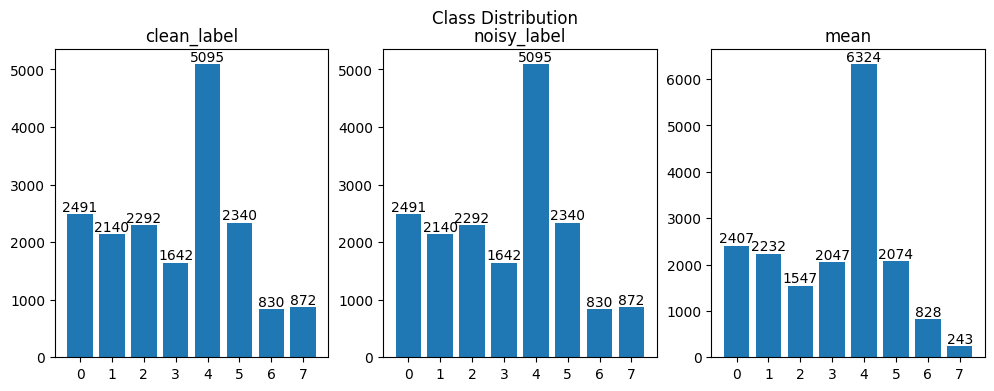

/home/vision/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vision/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


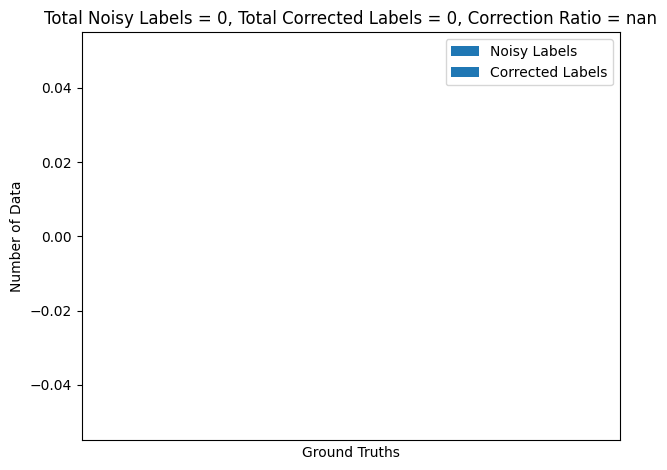

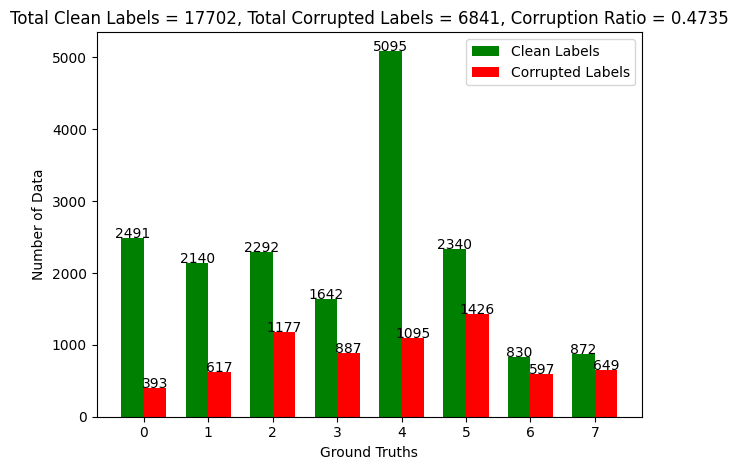

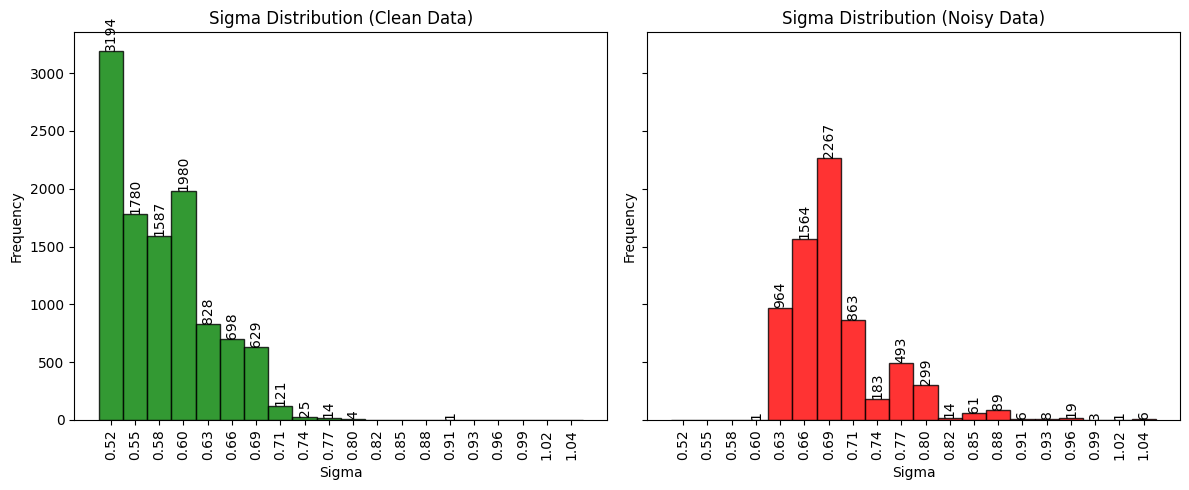

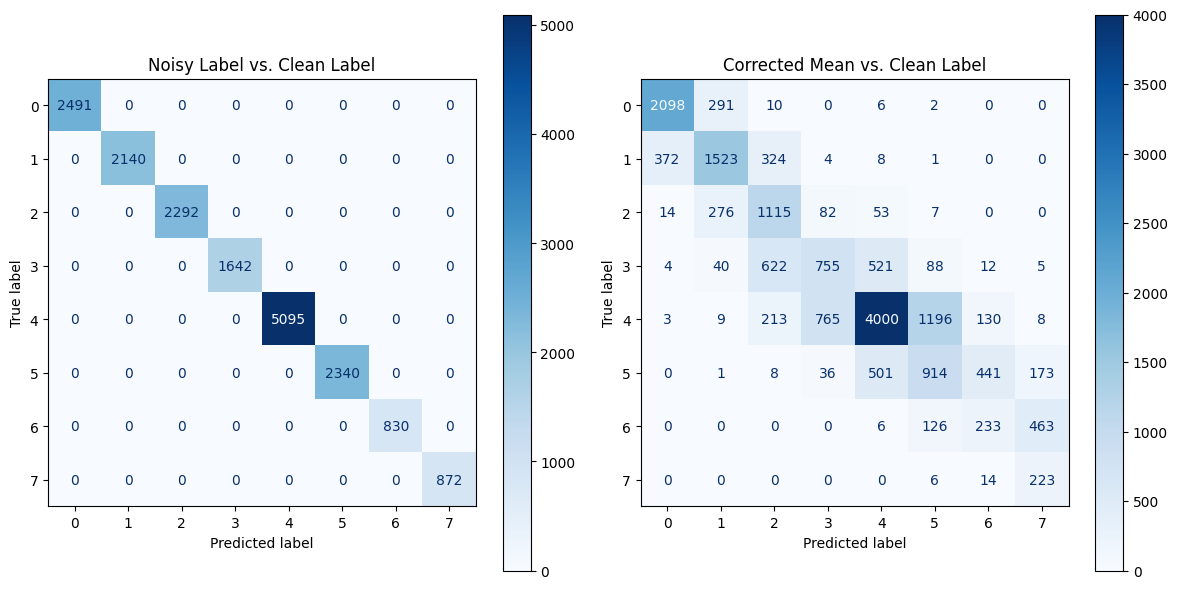

In [21]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6983
  RMSE: 1.2552


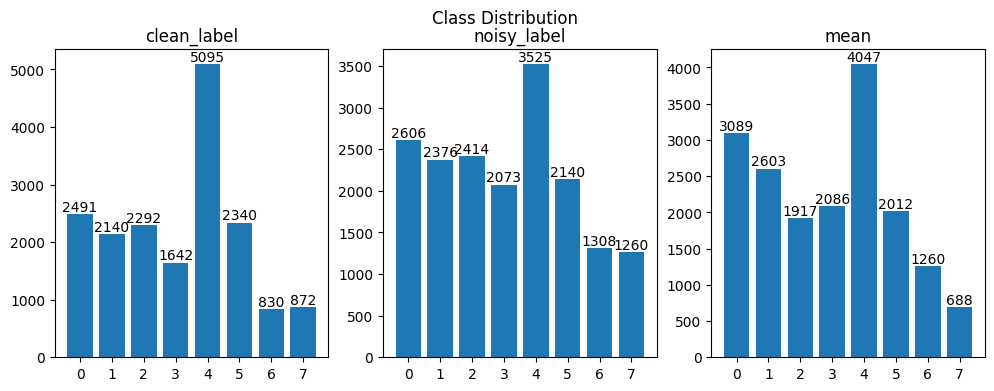

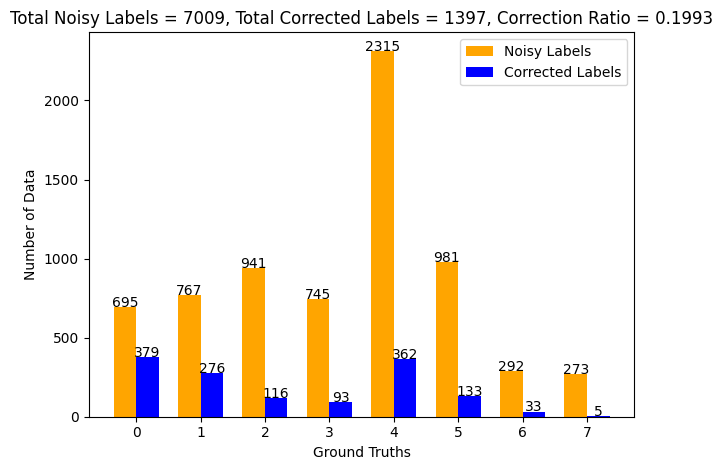

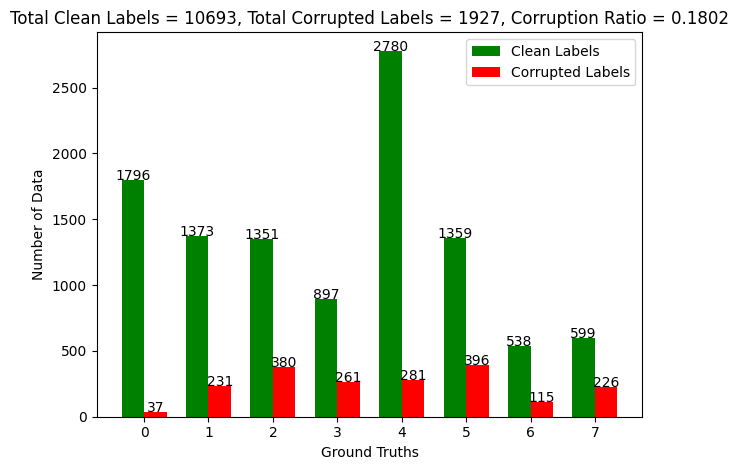

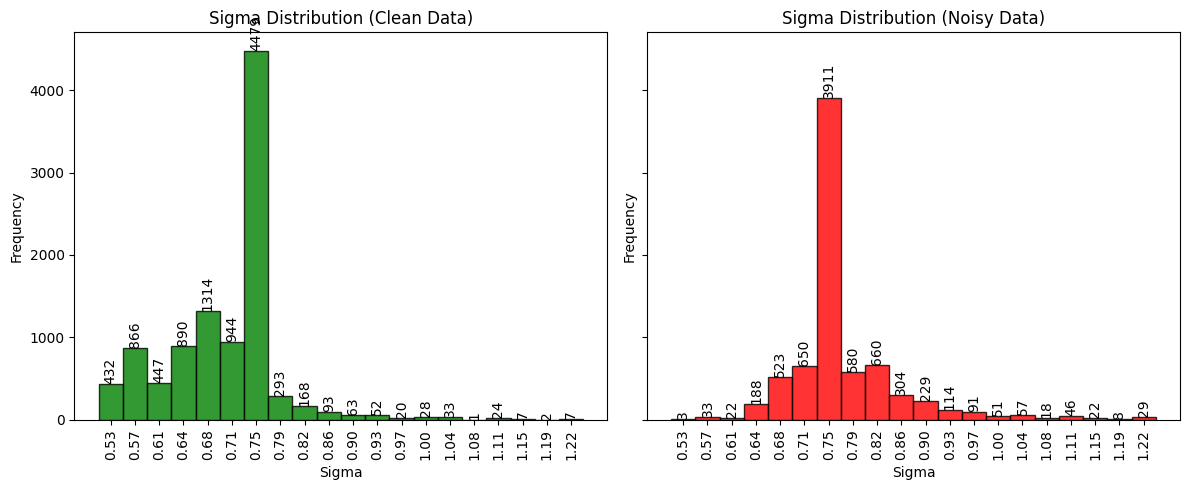

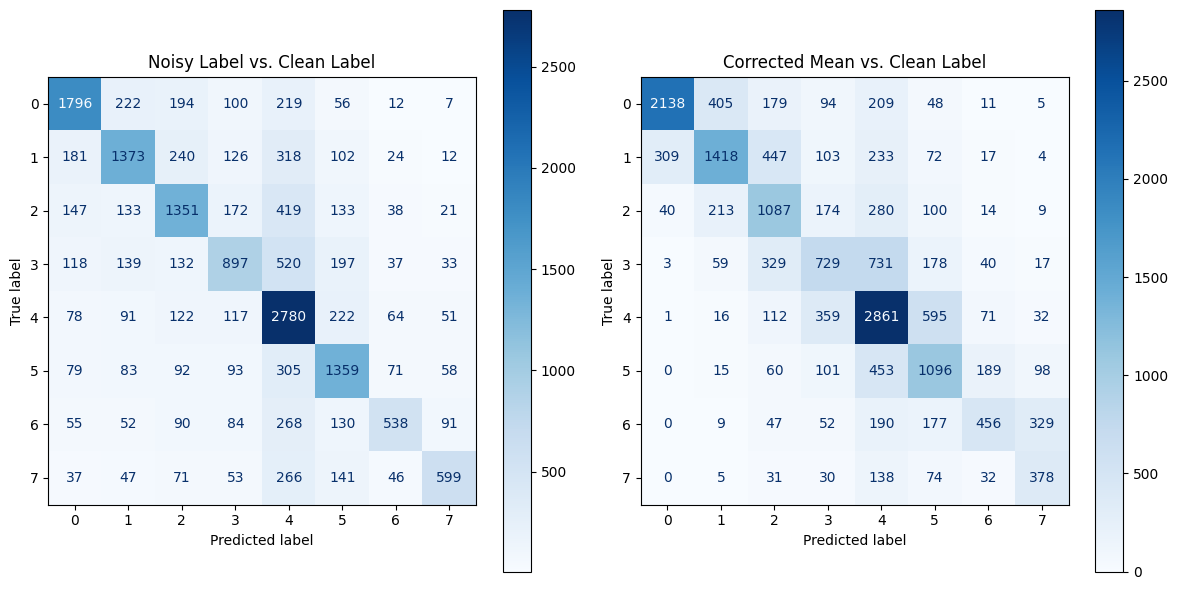

In [ ]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6513
  RMSE: 1.1653


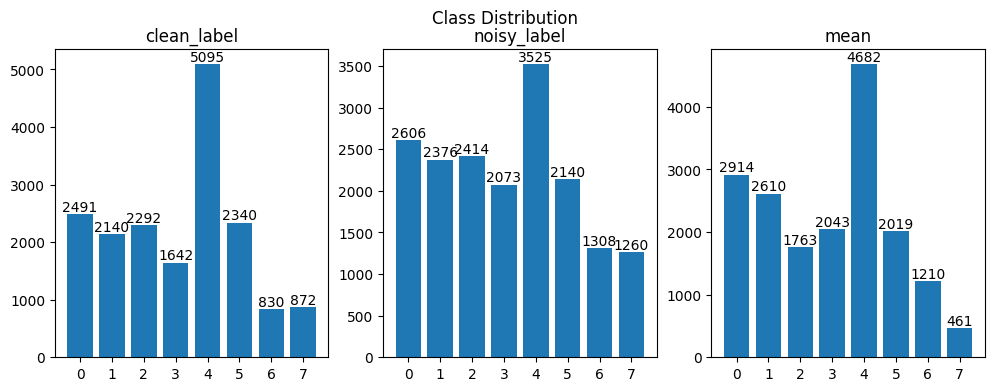

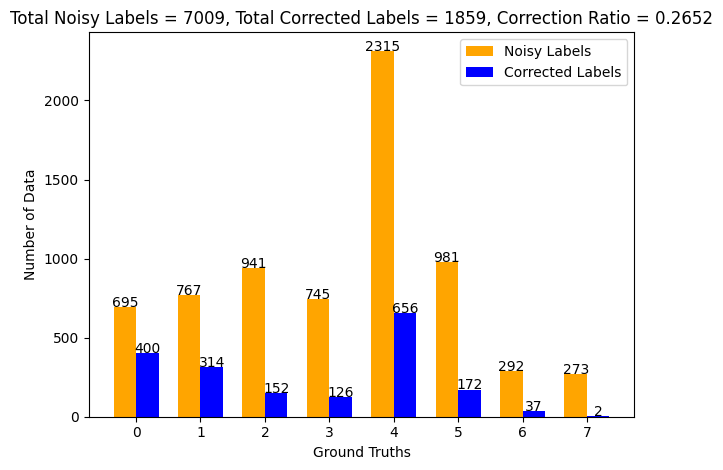

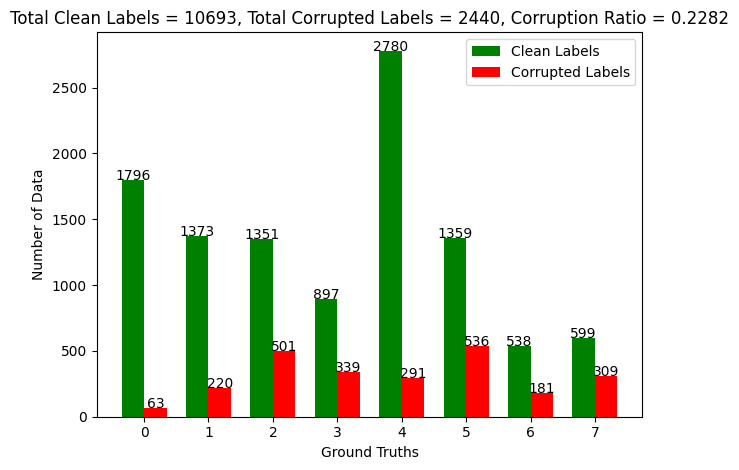

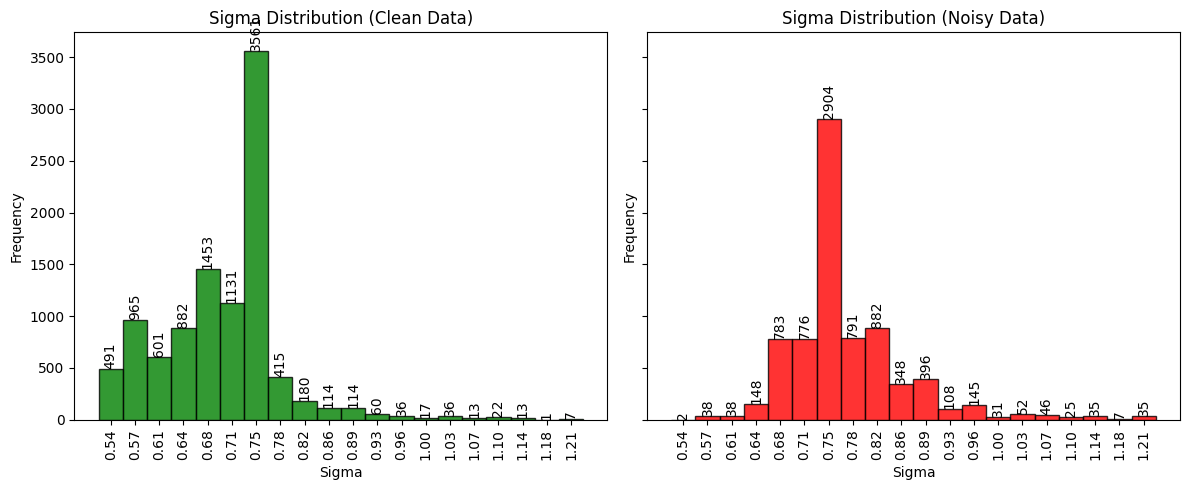

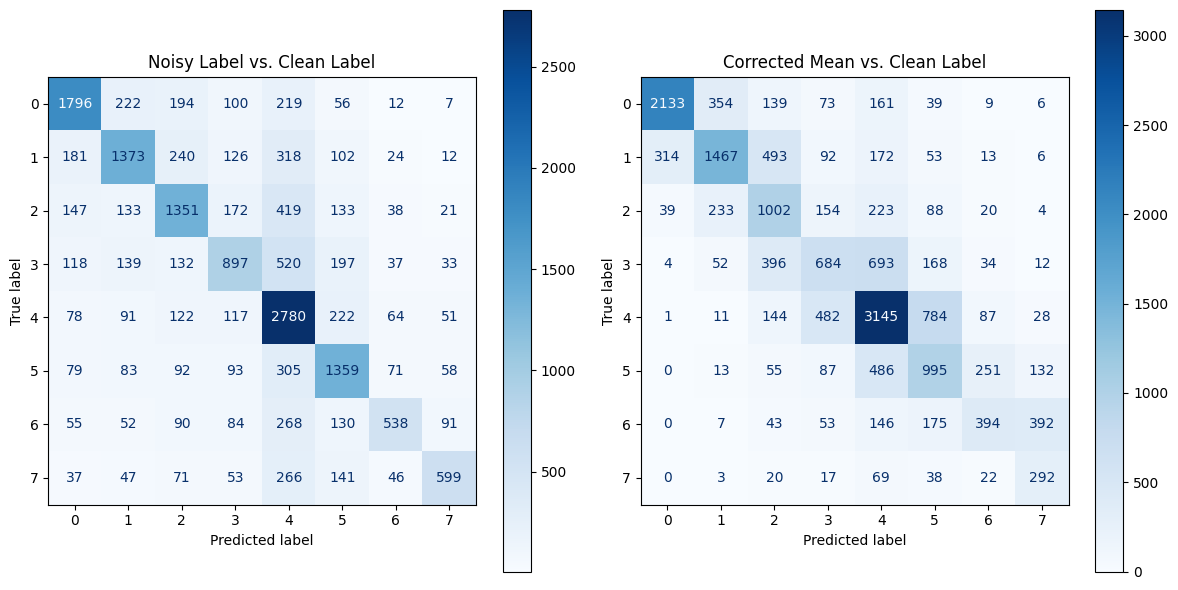

In [16]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_sigma

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.8898
  RMSE: 1.6375


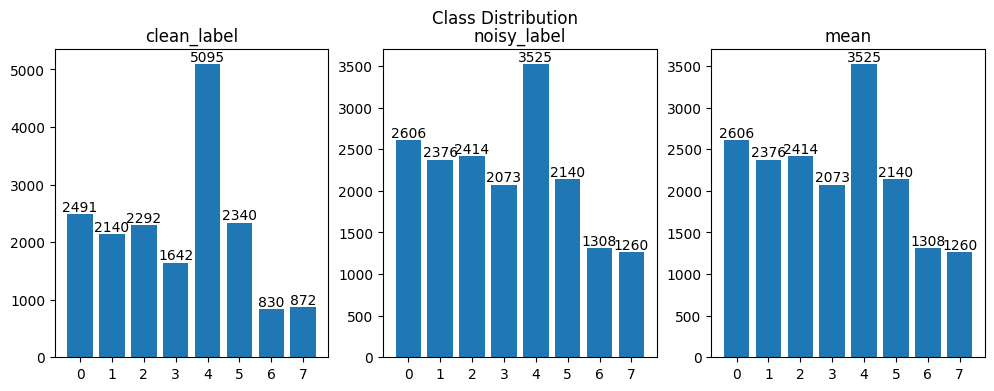

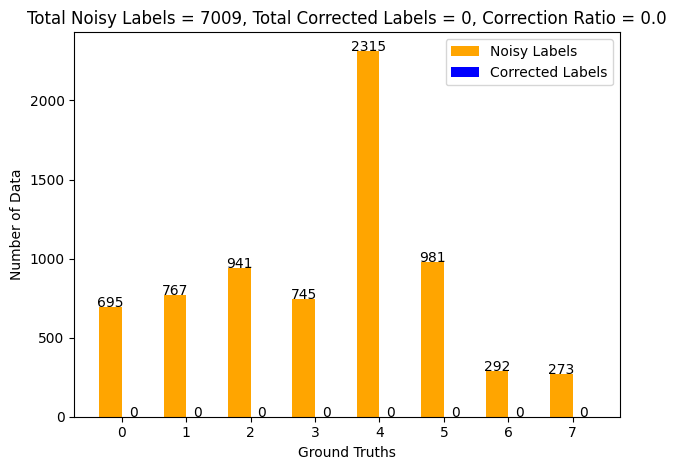

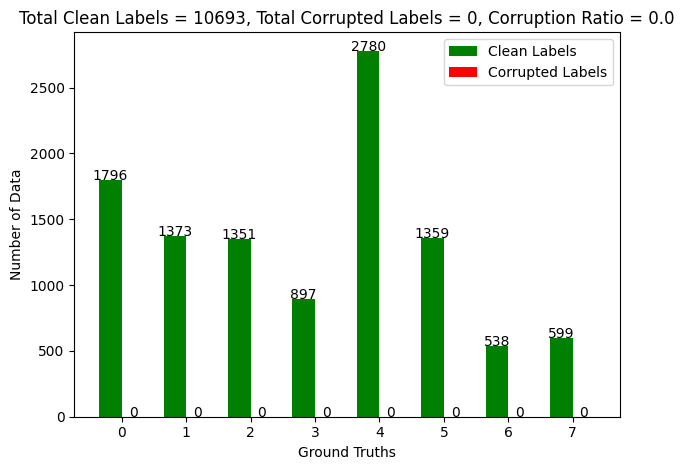

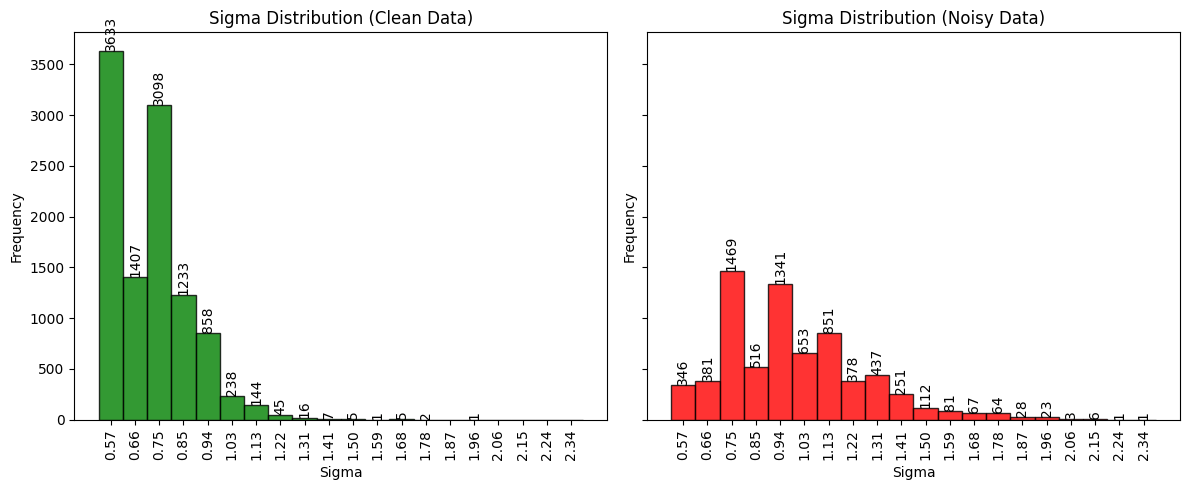

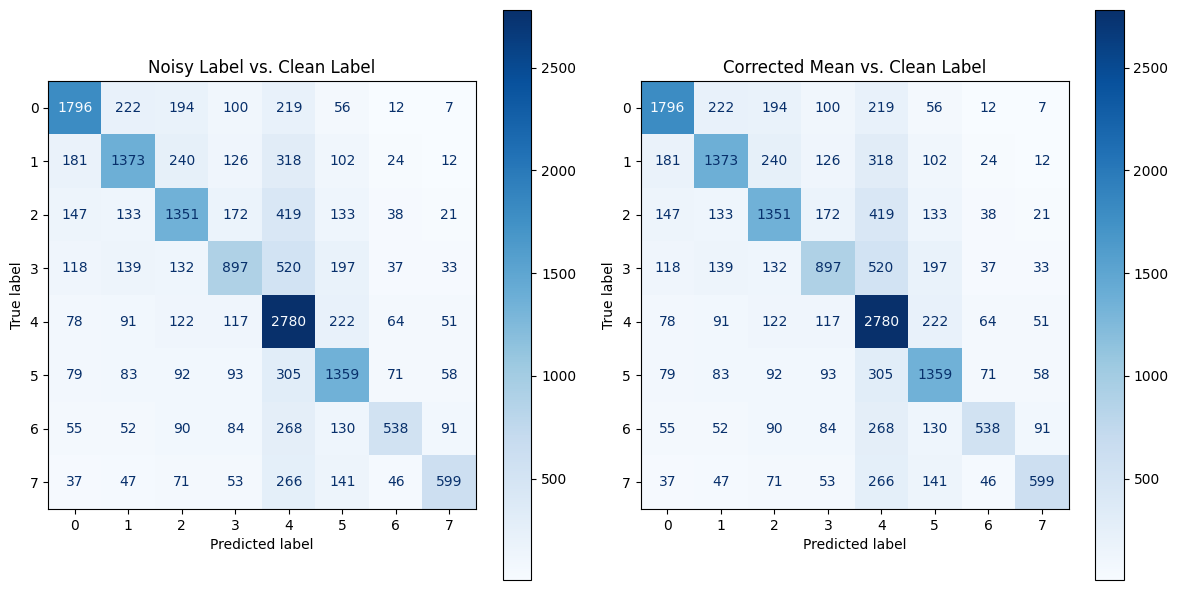

In [17]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_sigma',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_mean

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.5806
  RMSE: 0.8951


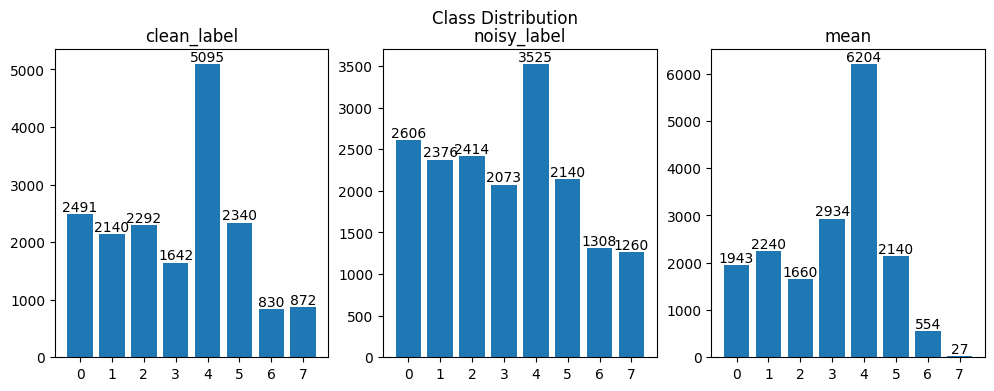

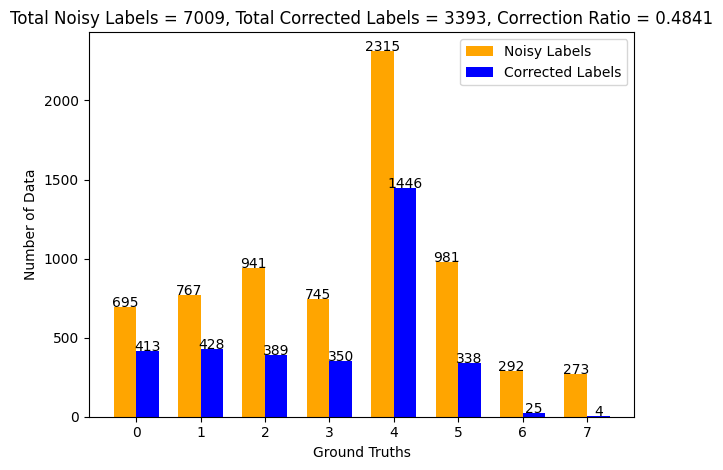

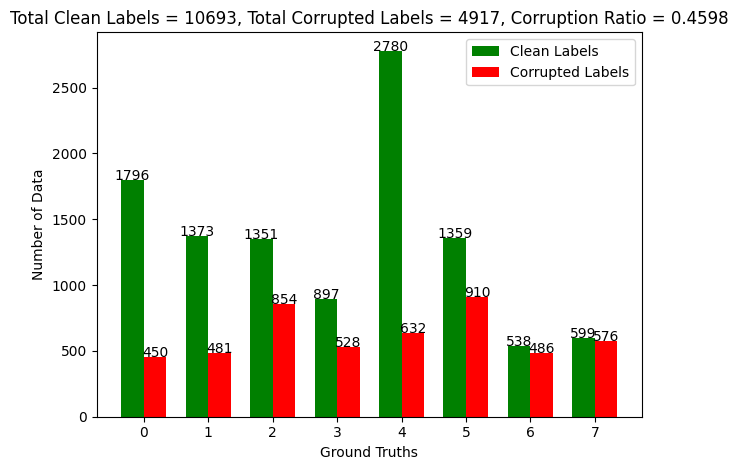

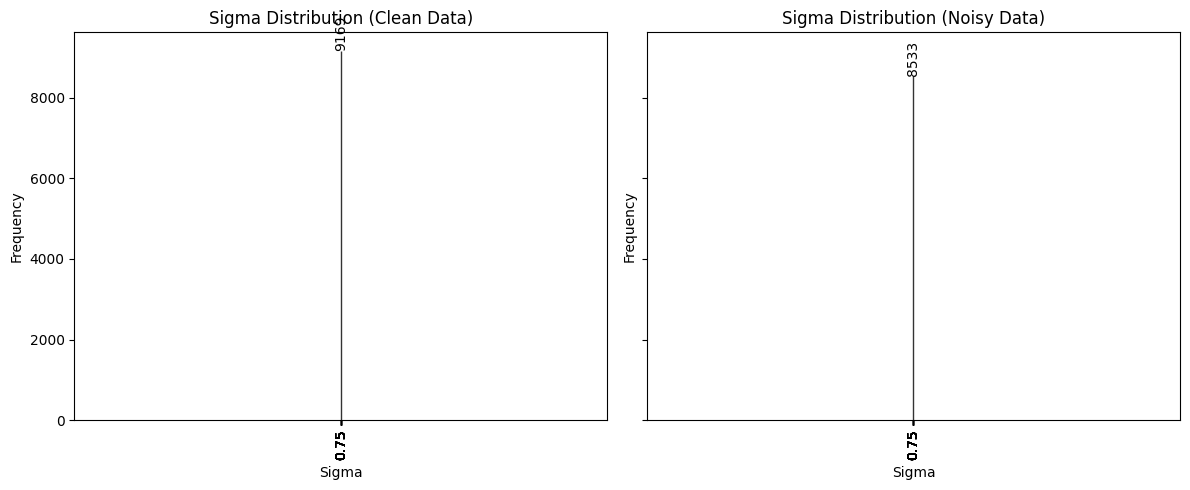

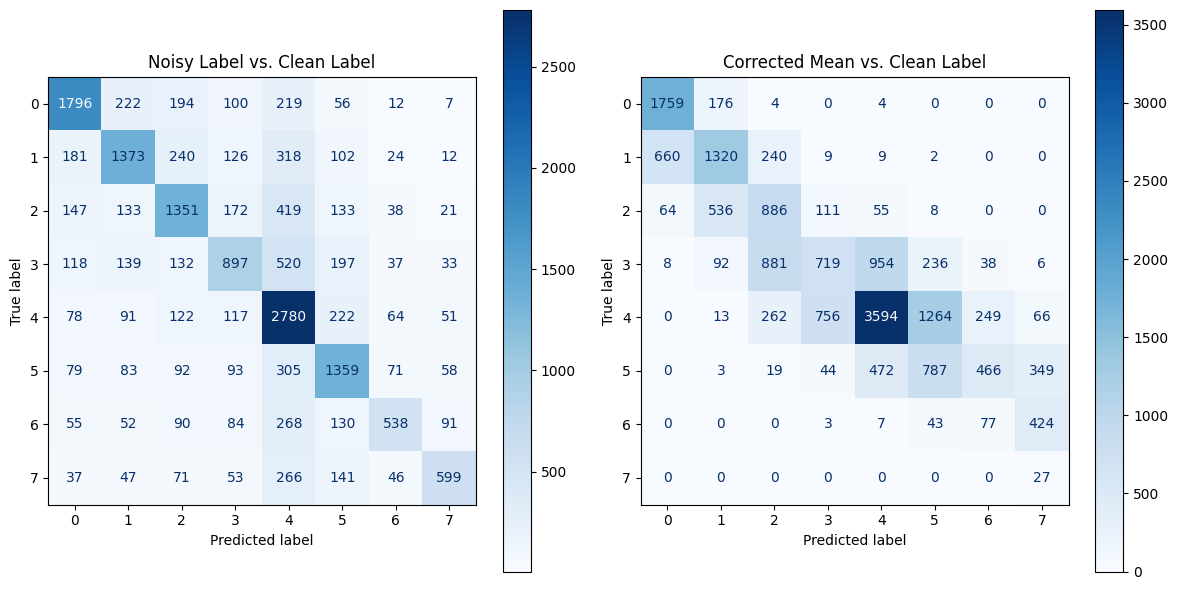

In [11]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_mean',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6294
  RMSE: 0.9920


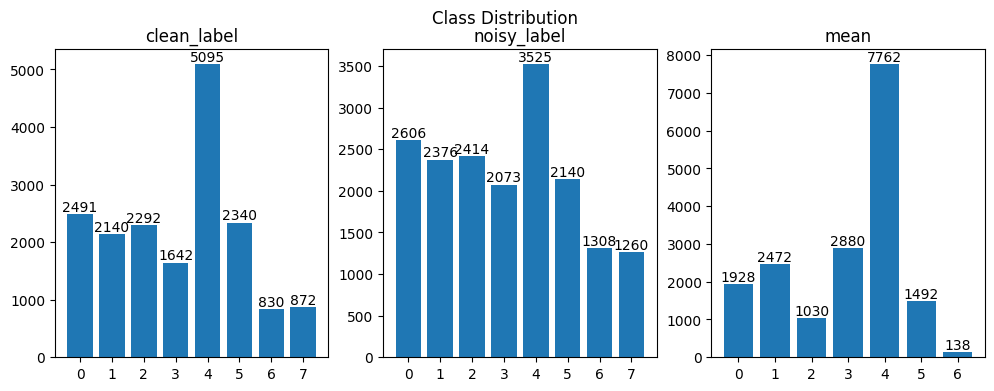

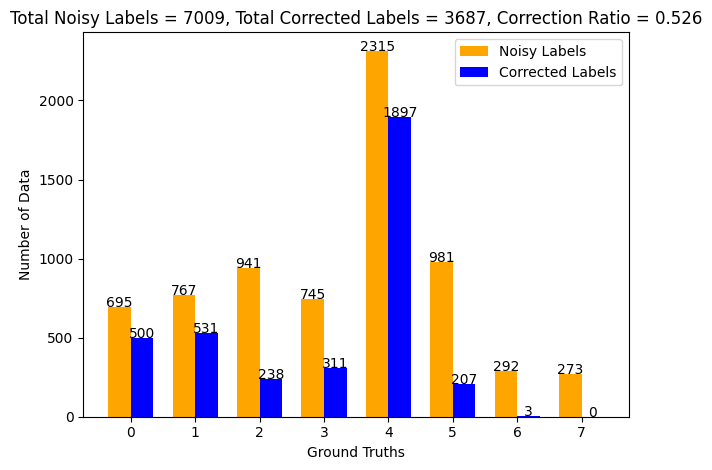

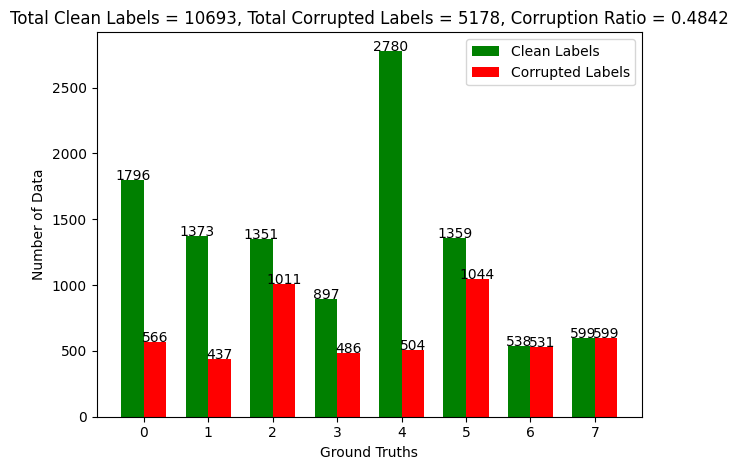

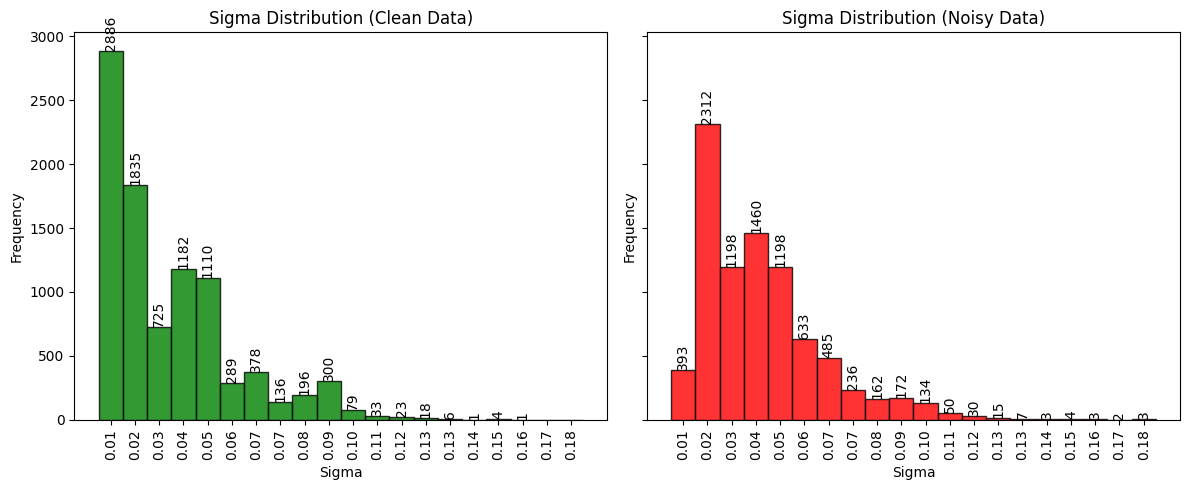

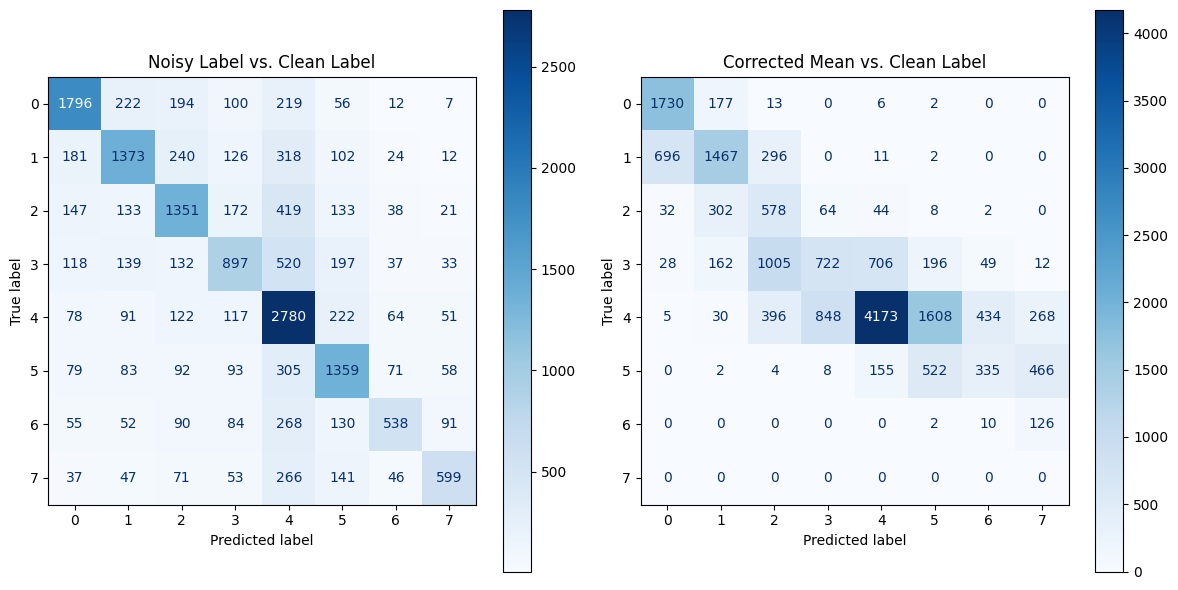

In [18]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl

Metrics between clean_label and noisy_label:
Overal MAE: 0.8898, Overal RMSE: 1.6375
Class-wise MAE: {0: 0.8531, 1: 0.8318, 2: 0.8704, 3: 0.908, 4: 0.9474, 5: 0.9038, 6: 0.8434, 7: 0.8234}
Class-wise RMSE: {0: 1.8846, 1: 1.6814, 2: 1.5741, 3: 1.4948, 4: 1.5558, 5: 1.5923, 6: 1.6812, 7: 1.7301}
Average MAE across classes: 0.8727
Average RMSE across classes: 1.6493

Metrics between clean_label and rounded mean:
Overal MAE: 0.5715, Overal RMSE: 0.8856
Class-wise MAE: {0: 0.332, 1: 0.4079, 2: 0.7282, 3: 0.5609, 4: 0.3256, 5: 0.75, 6: 1.2771, 7: 1.5505}
Class-wise RMSE: {0: 0.6314, 1: 0.7347, 2: 0.9906, 3: 0.78, 4: 0.6066, 5: 0.9882, 6: 1.4767, 7: 1.6986}
Average MAE across classes: 0.7415
Average RMSE across classes: 0.9884


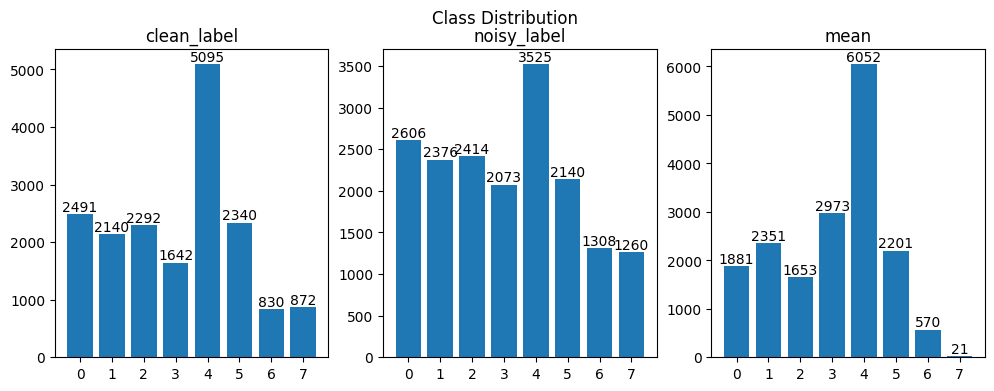

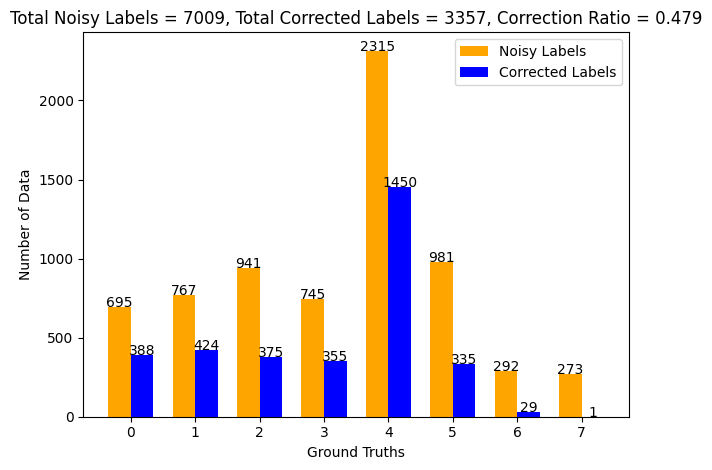

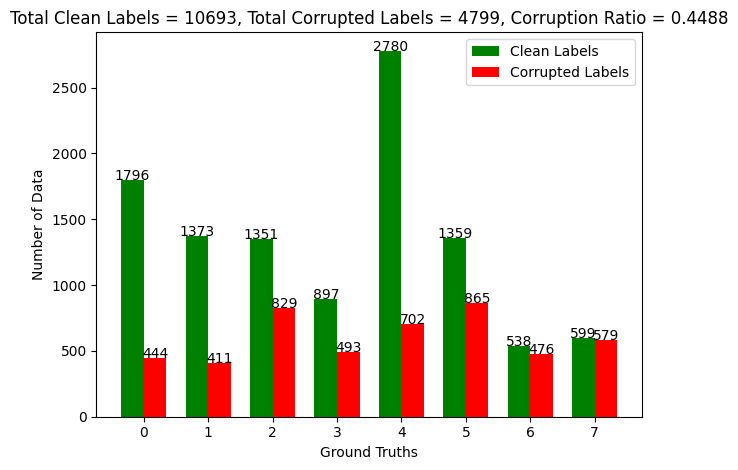

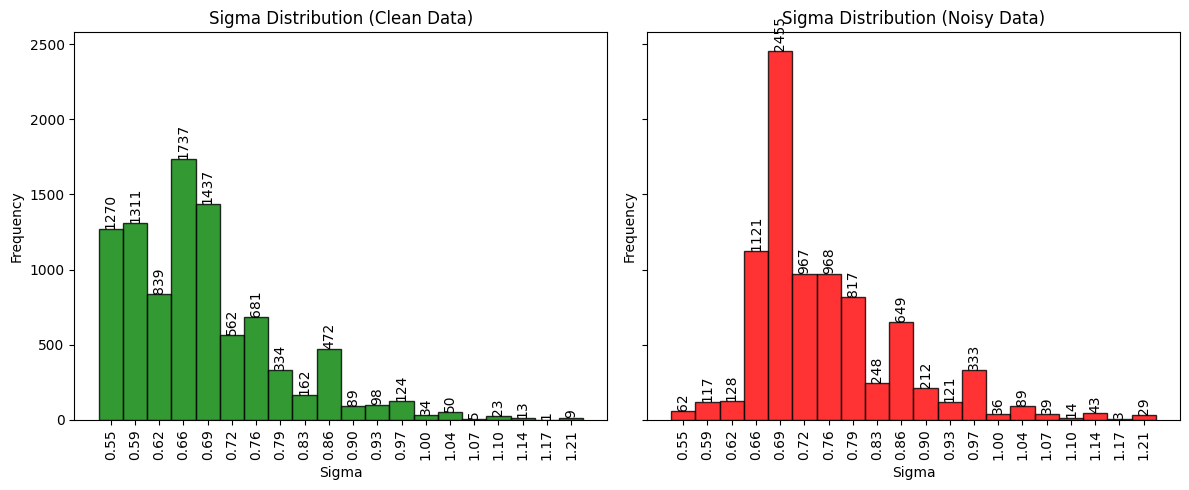

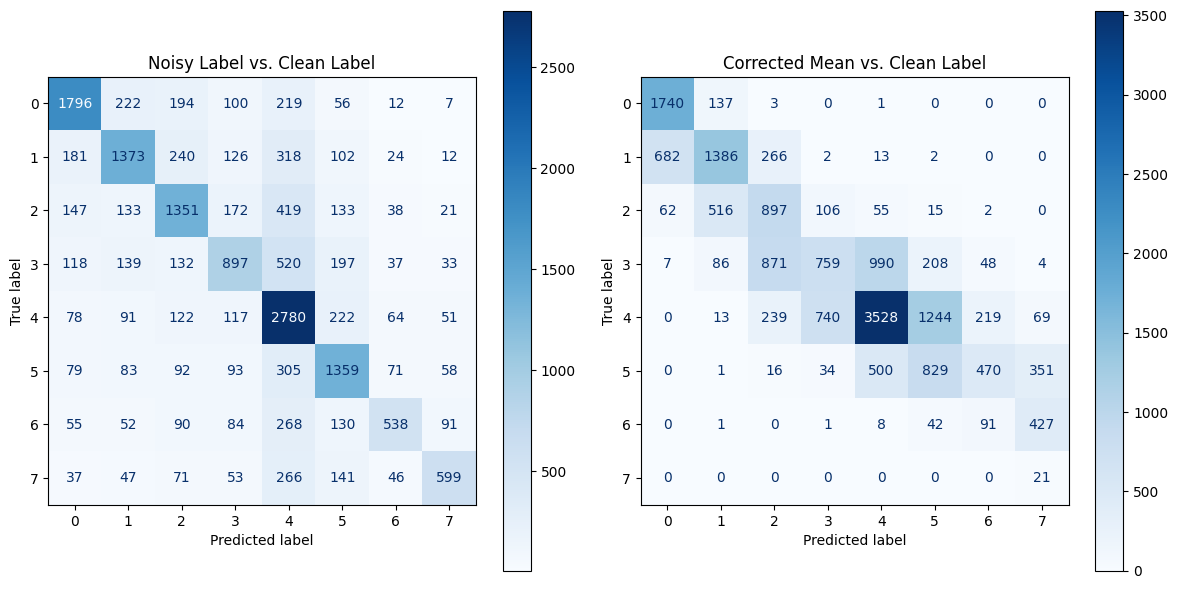

In [33]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v2

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6657
  RMSE: 1.0320


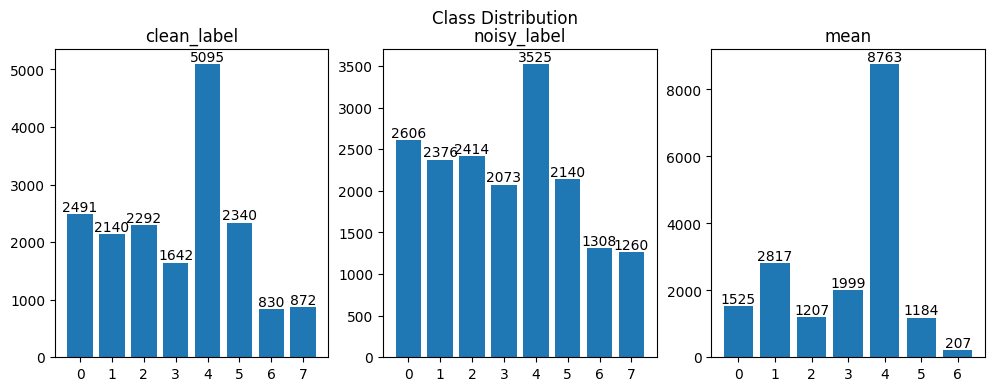

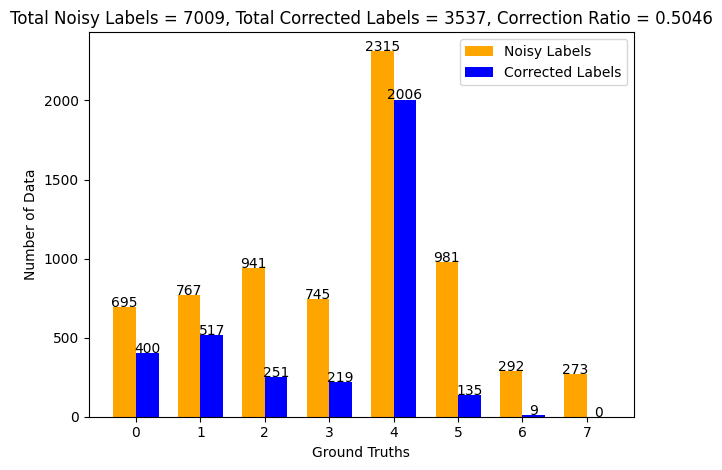

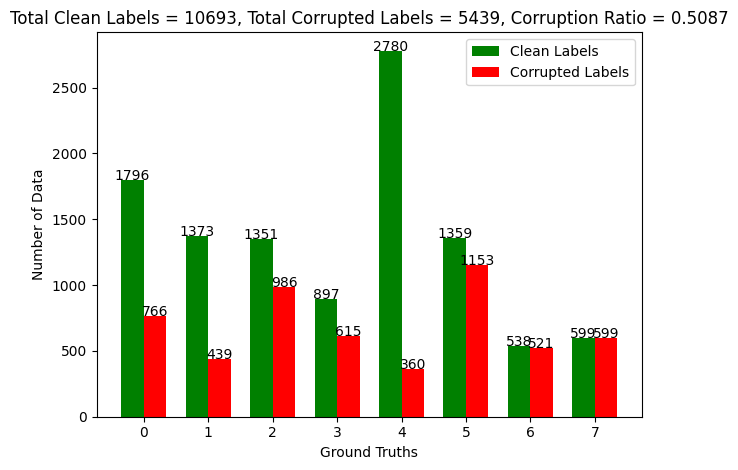

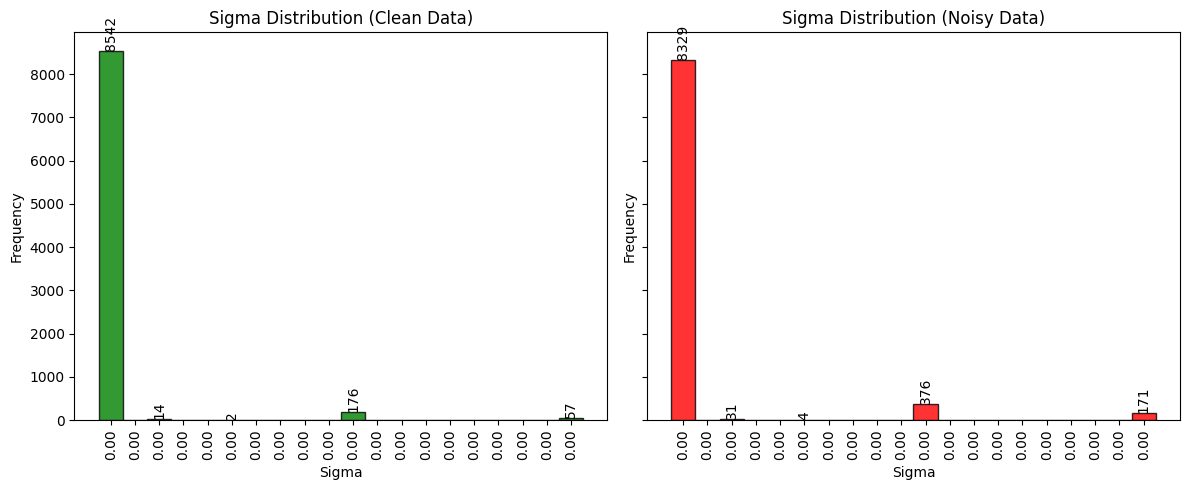

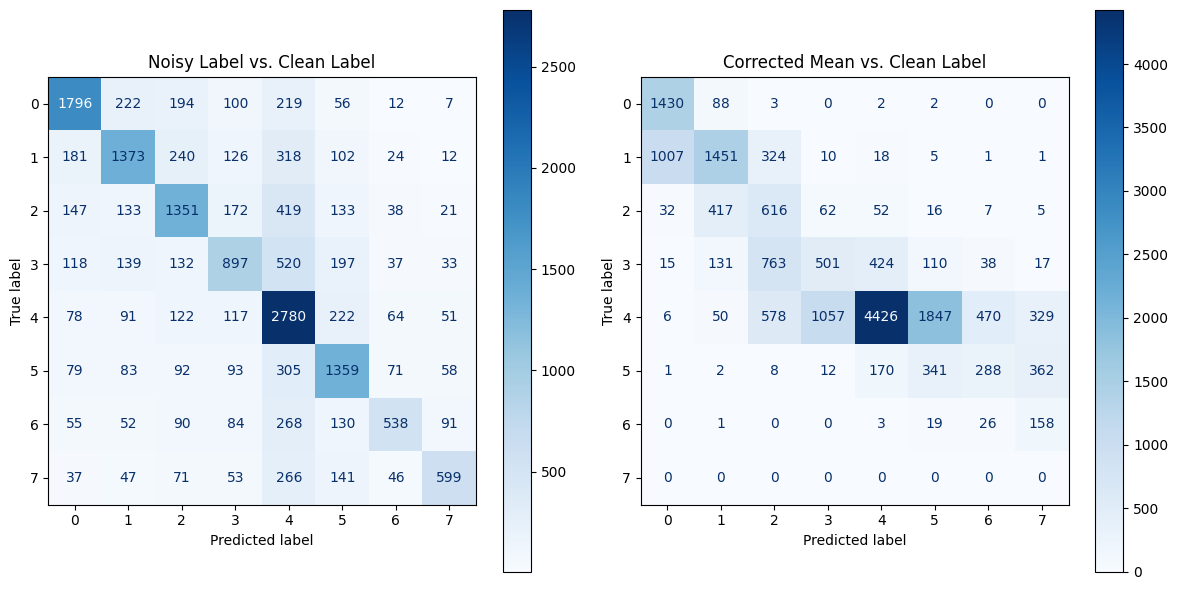

In [22]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v2',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_high_alpha

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.5785
  RMSE: 0.8968


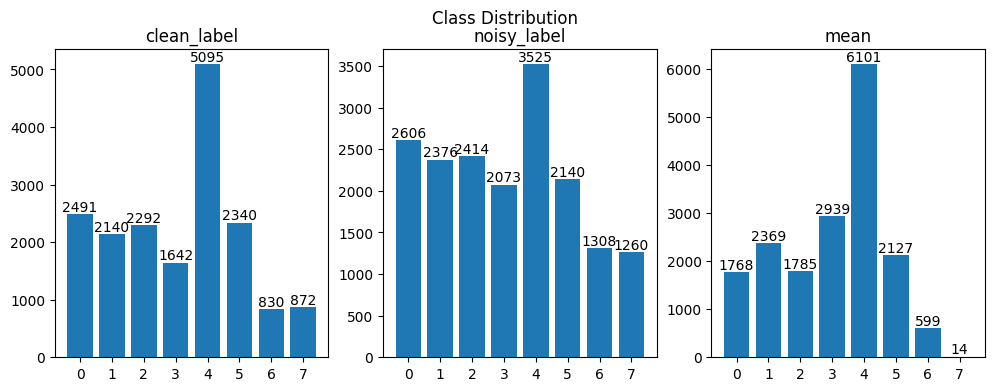

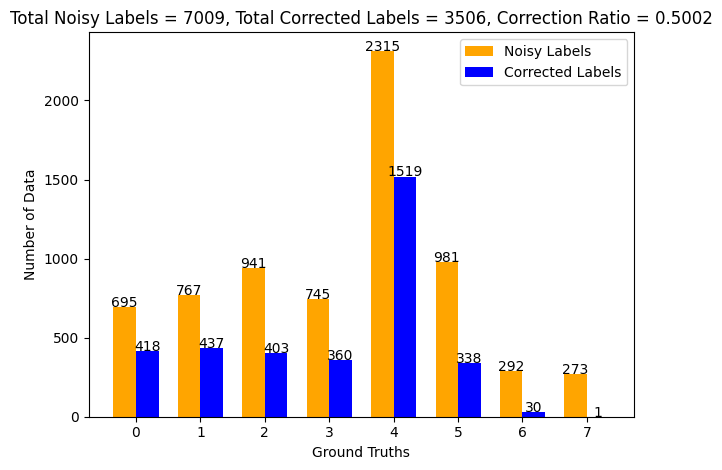

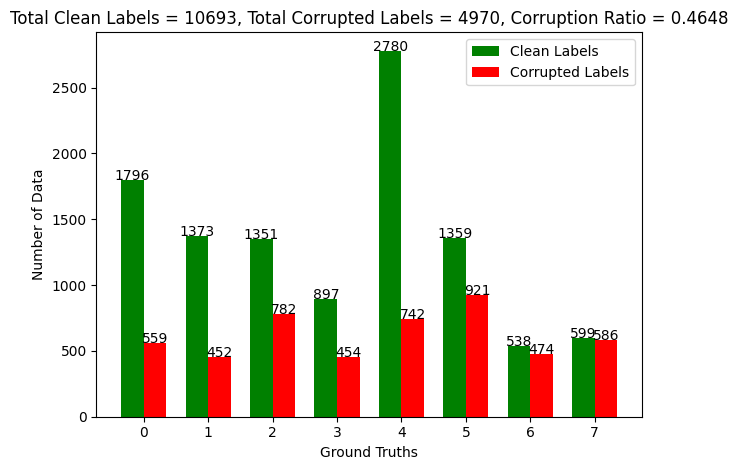

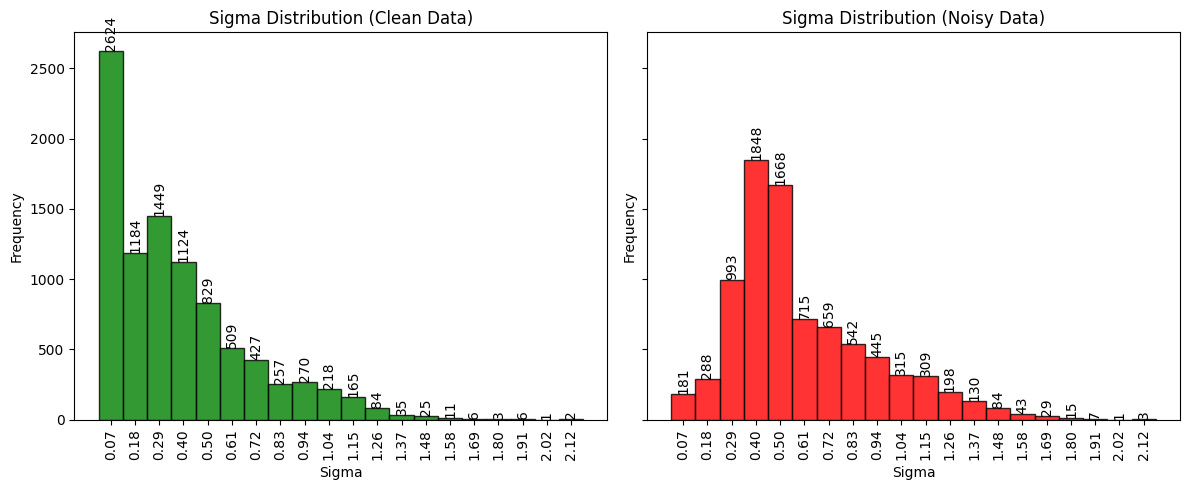

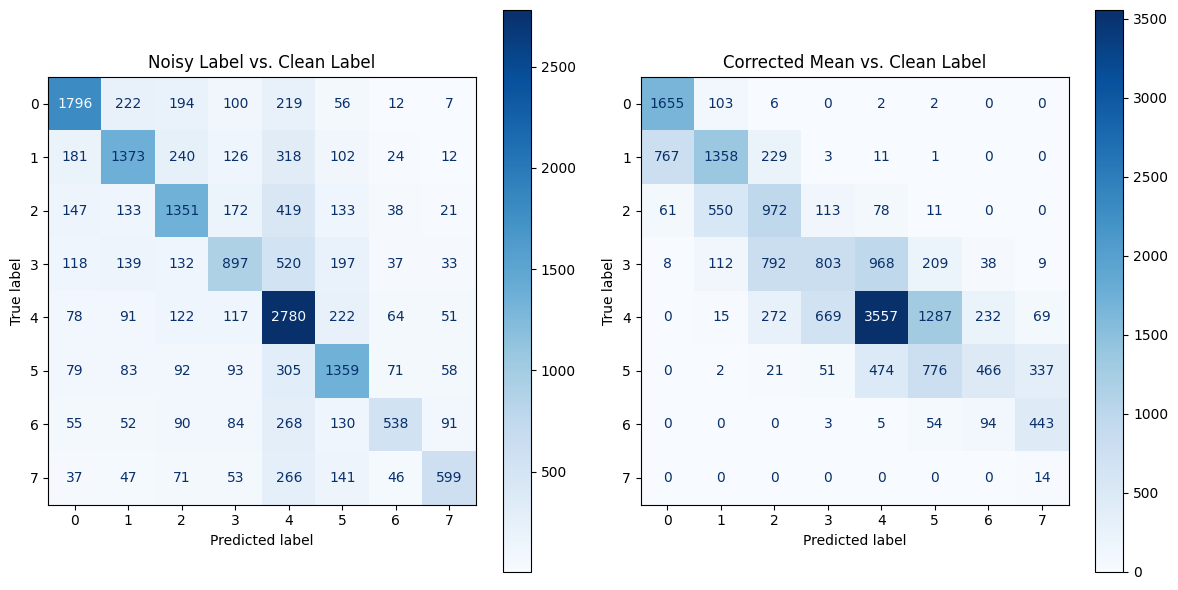

In [23]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_high_alpha',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.5789
  RMSE: 0.8912


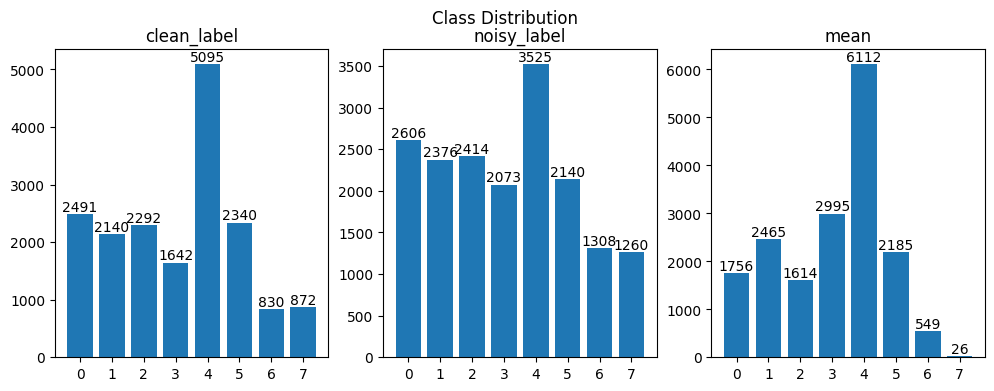

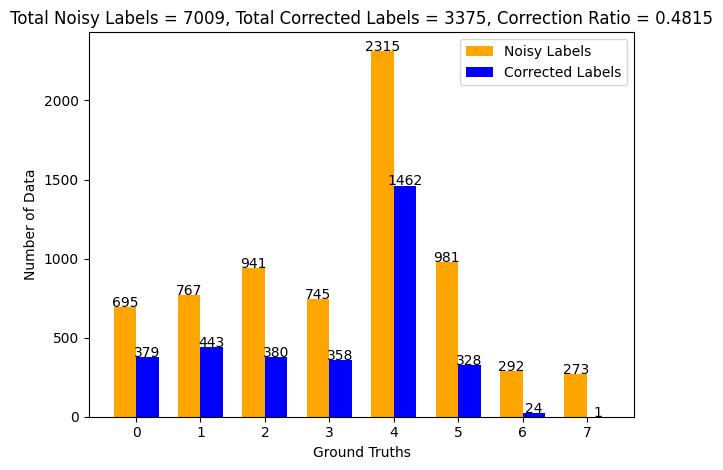

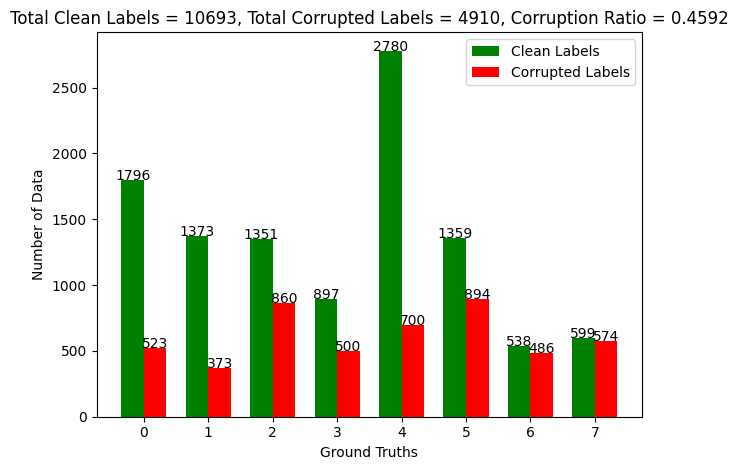

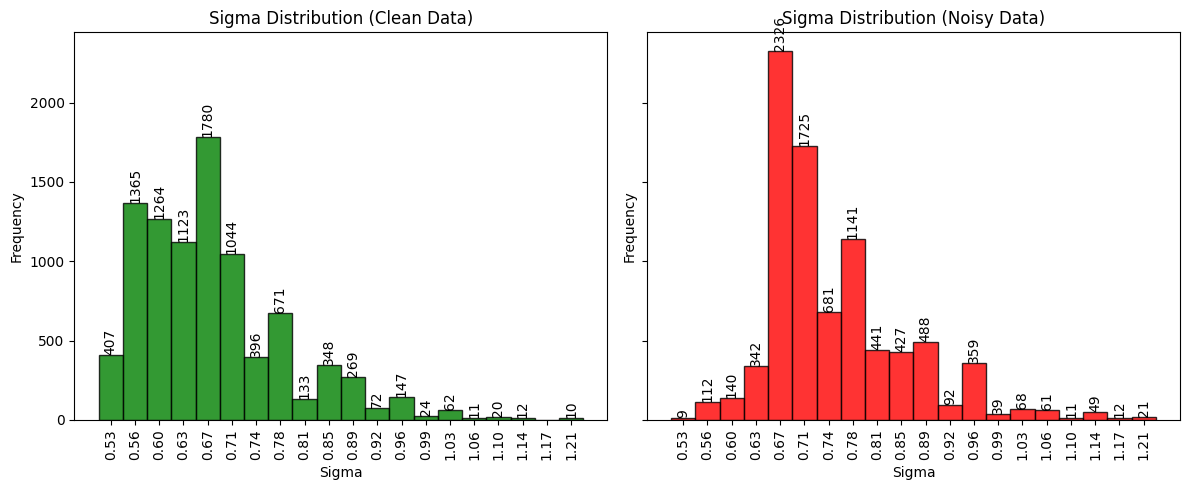

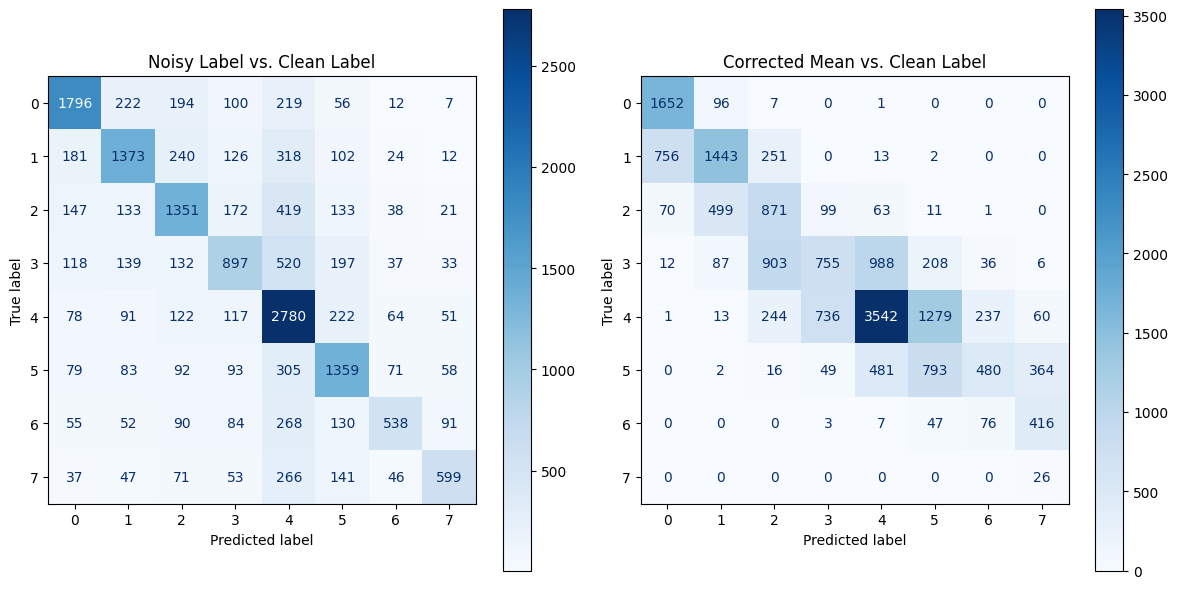

In [24]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl_v2

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.5715
  RMSE: 0.8856


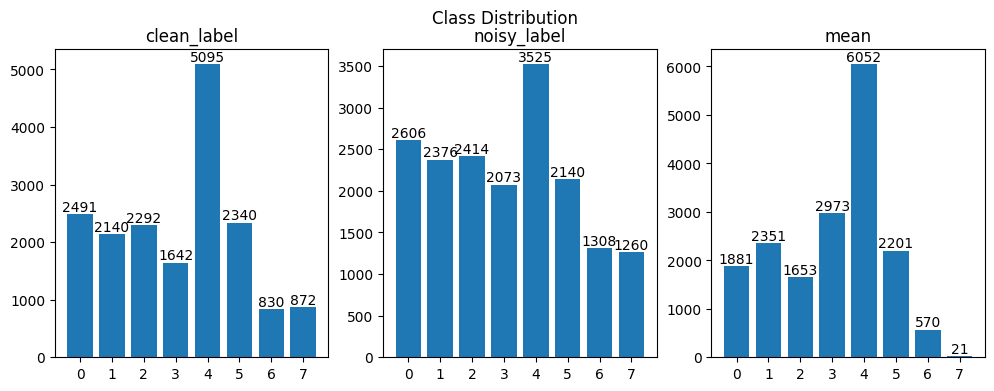

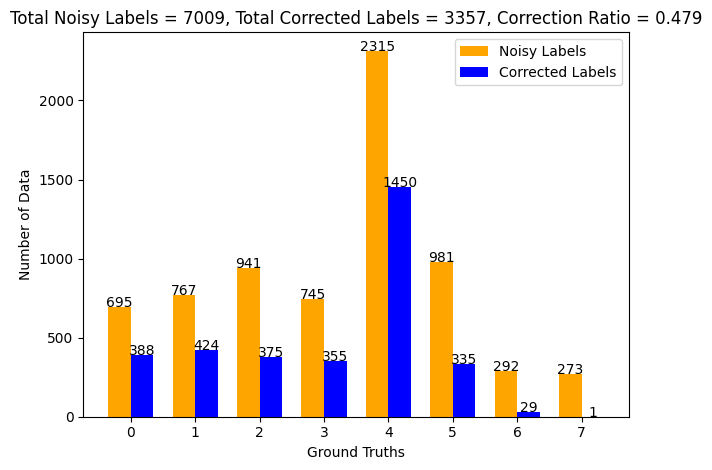

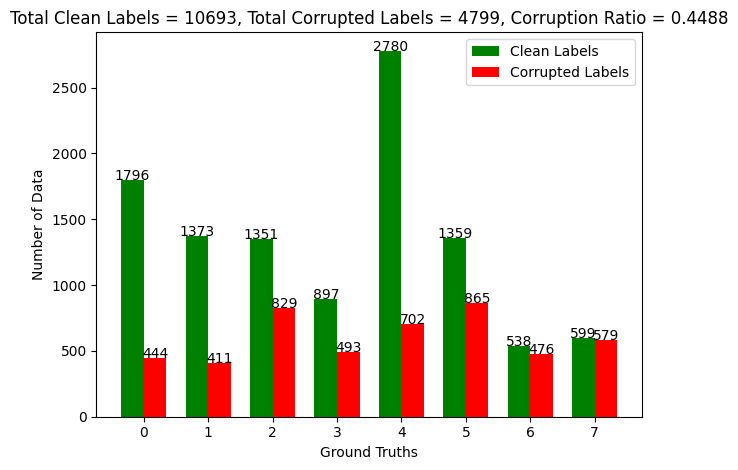

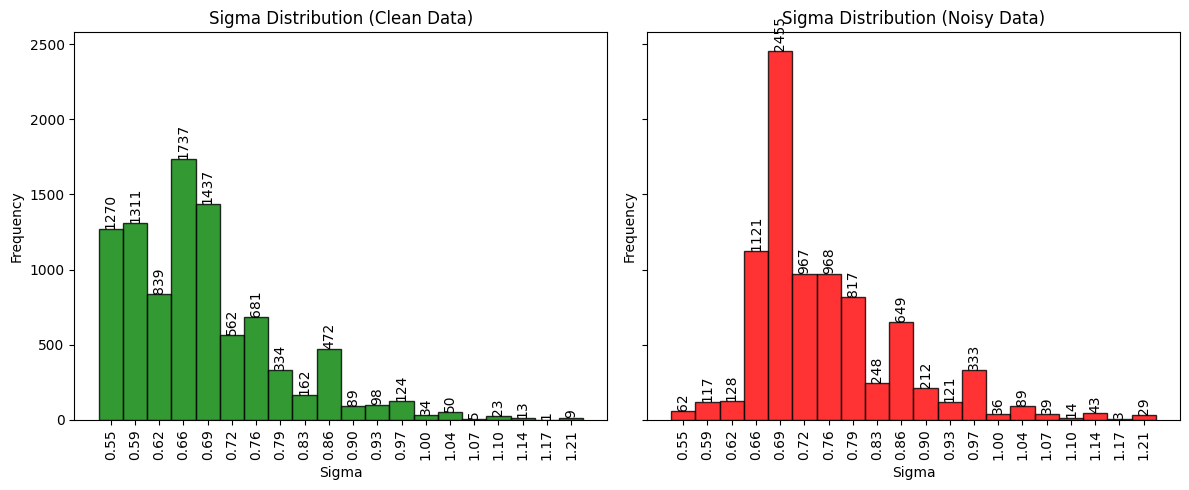

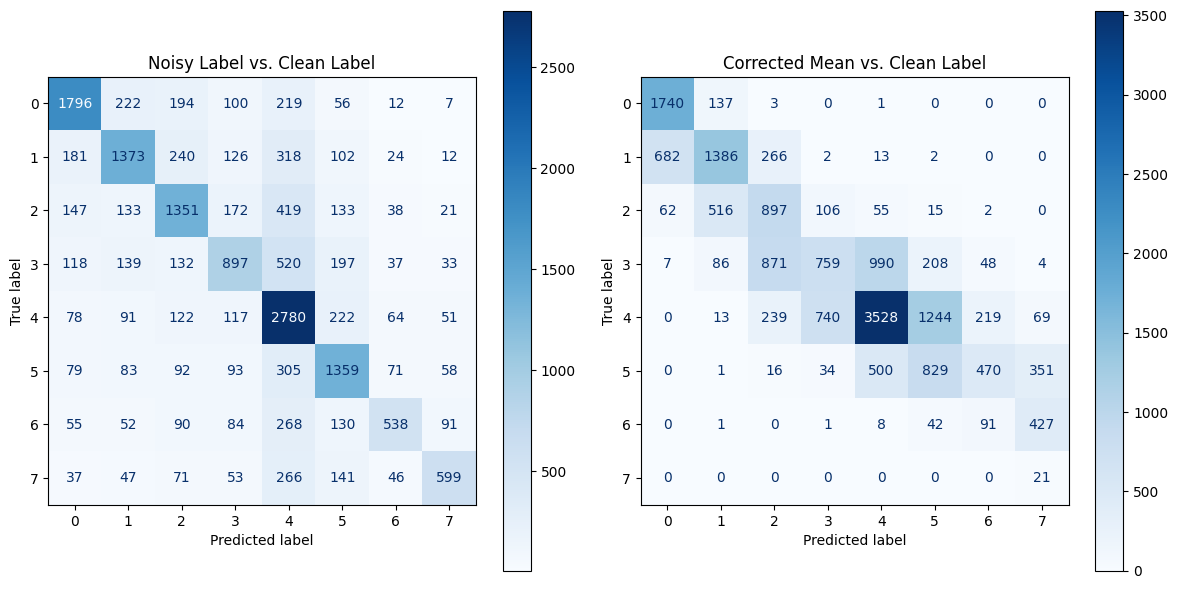

In [11]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl_v2',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 1.1318
  RMSE: 1.4954


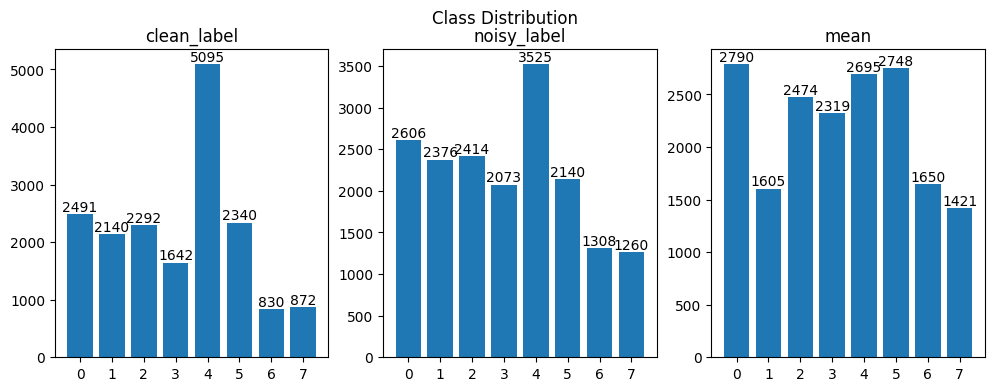

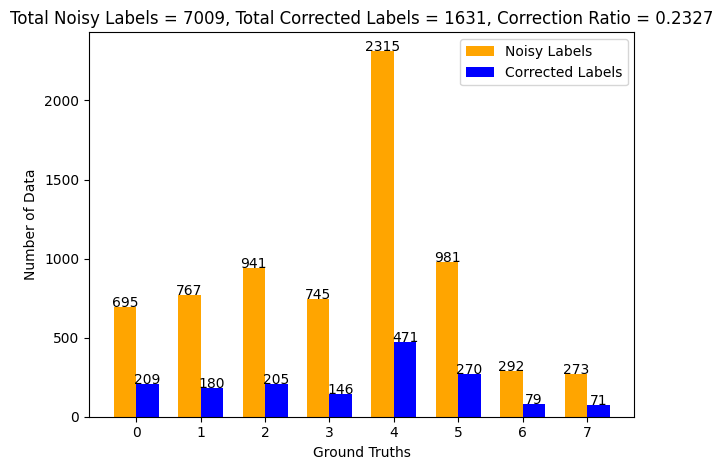

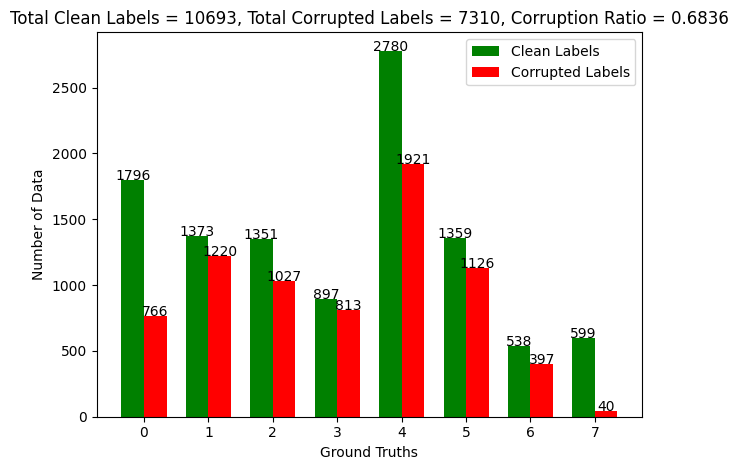

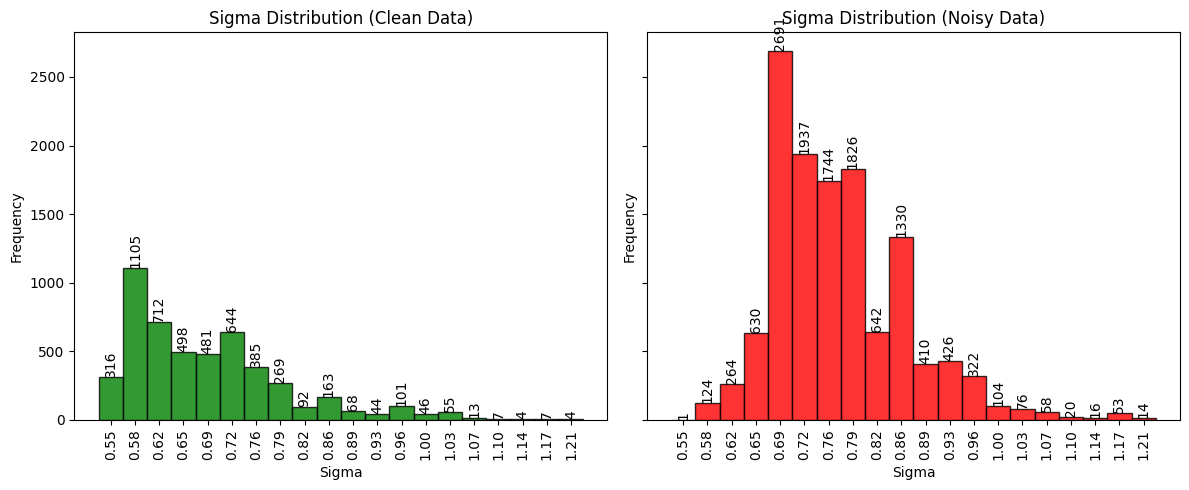

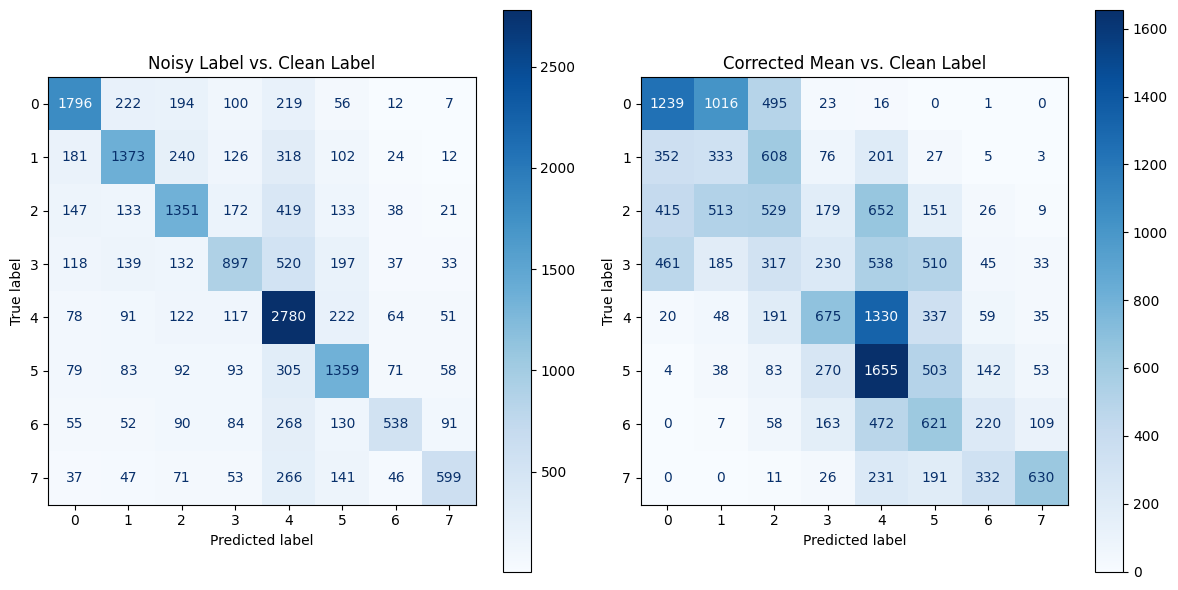

In [25]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v2

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.8106
  RMSE: 1.2114


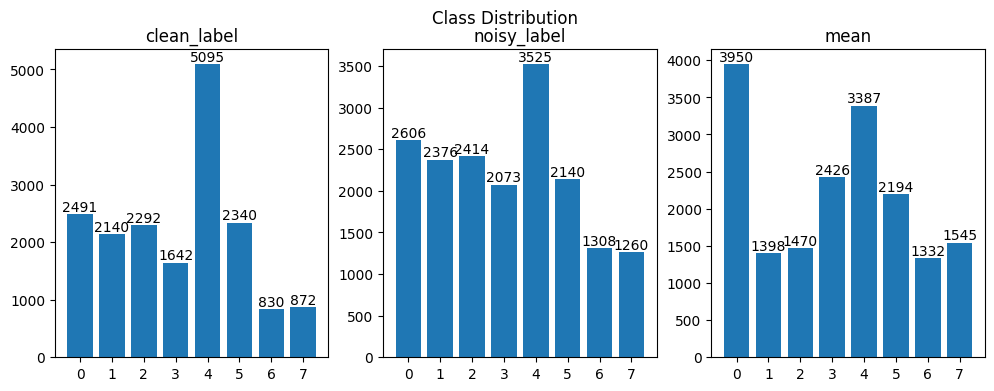

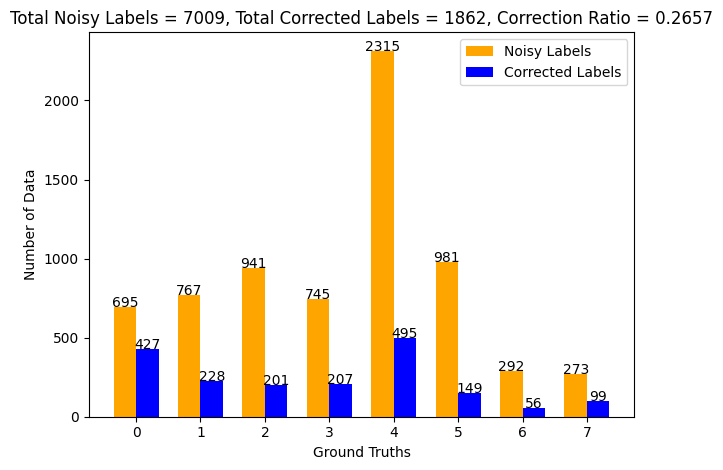

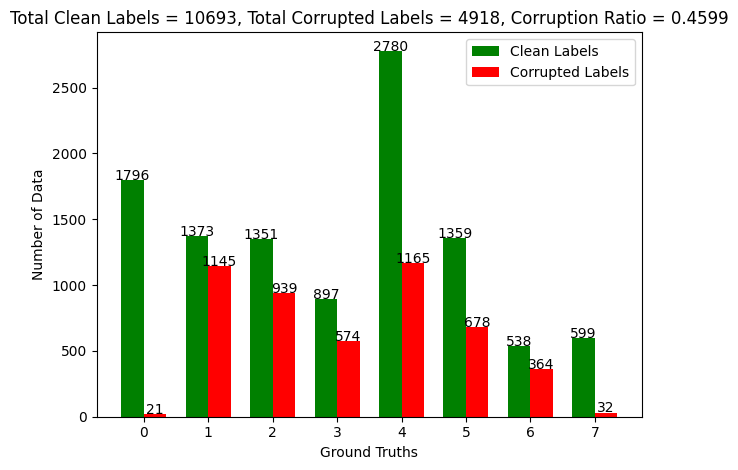

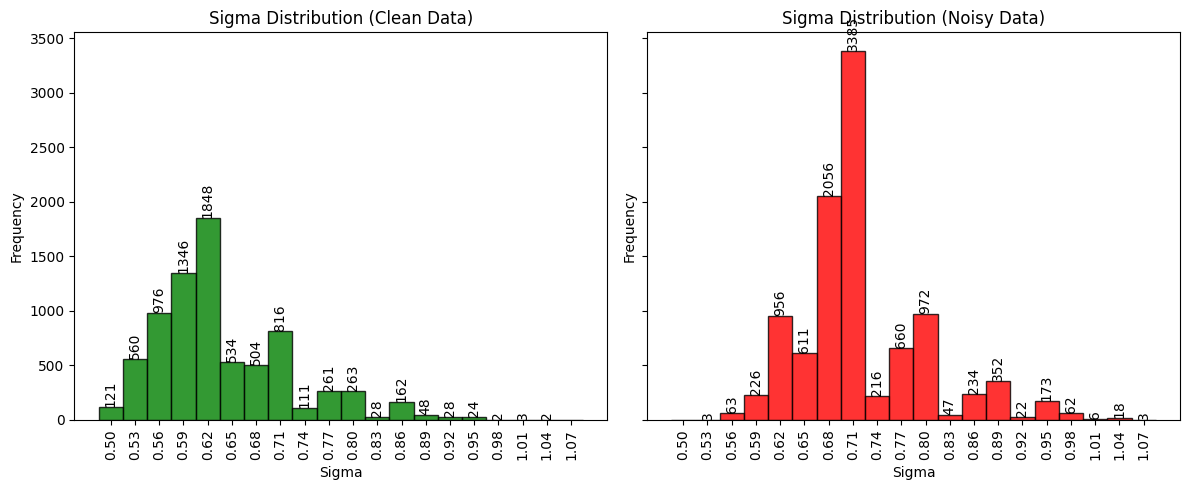

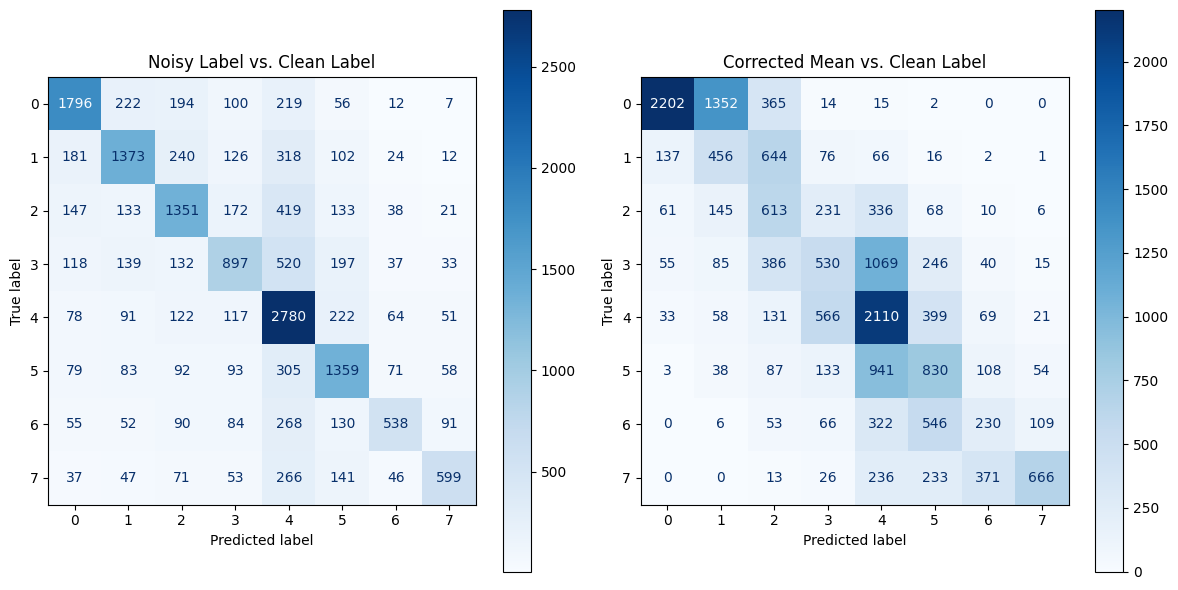

In [12]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v2',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3

Metrics between clean_label and noisy_label:
MAE : {0: 0.8531, 1: 0.8318, 2: 0.8704, 3: 0.908, 4: 0.9474, 5: 0.9038, 6: 0.8434, 7: 0.8234}
RMSE: {0: 1.8846, 1: 1.6814, 2: 1.5741, 3: 1.4948, 4: 1.5558, 5: 1.5923, 6: 1.6812, 7: 1.7301}
overal MAE: 0.8898, overal RMSE: 1.6375
class MAE : 0.8727, class RMSE : 1.6493

Metrics between clean_label and rounded mean:
MAE : {0: 0.1951, 1: 0.5136, 2: 0.839, 3: 0.824, 4: 0.7515, 5: 0.8338, 6: 0.7301, 7: 0.4977}
RMSE: {0: 0.4825, 1: 0.7963, 2: 1.174, 3: 1.144, 4: 1.0652, 5: 1.1449, 6: 1.1407, 7: 0.9674}
overal MAE: 0.6599, overal RMSE: 1.0081
class MAE : 0.6481, class RMSE : 0.9894


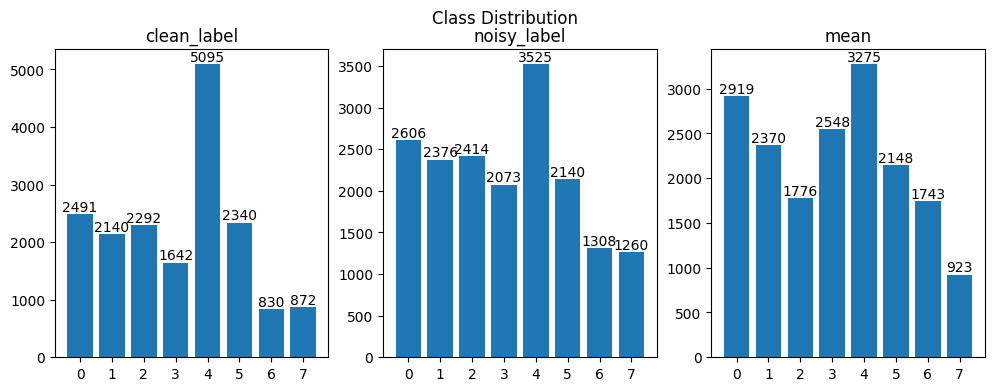

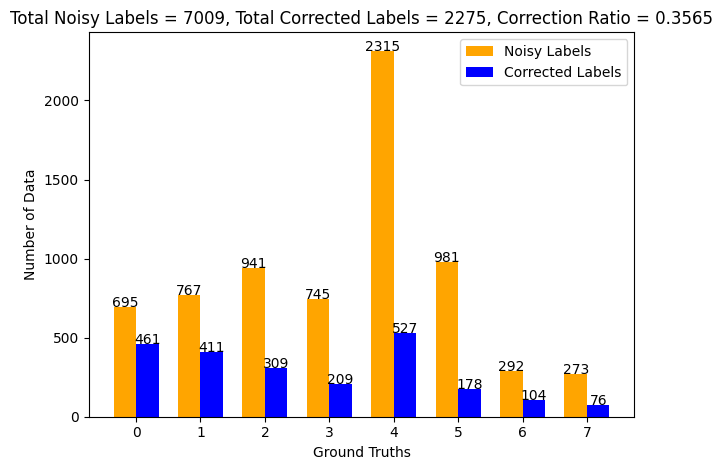

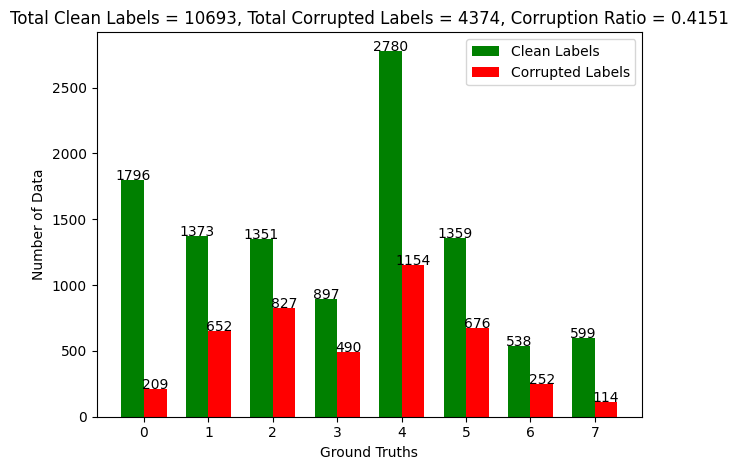

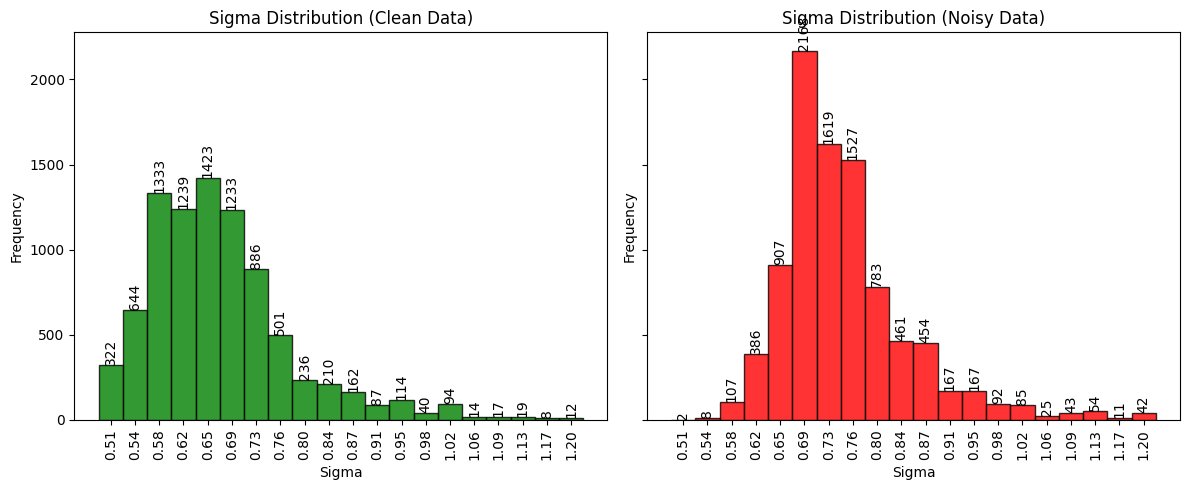

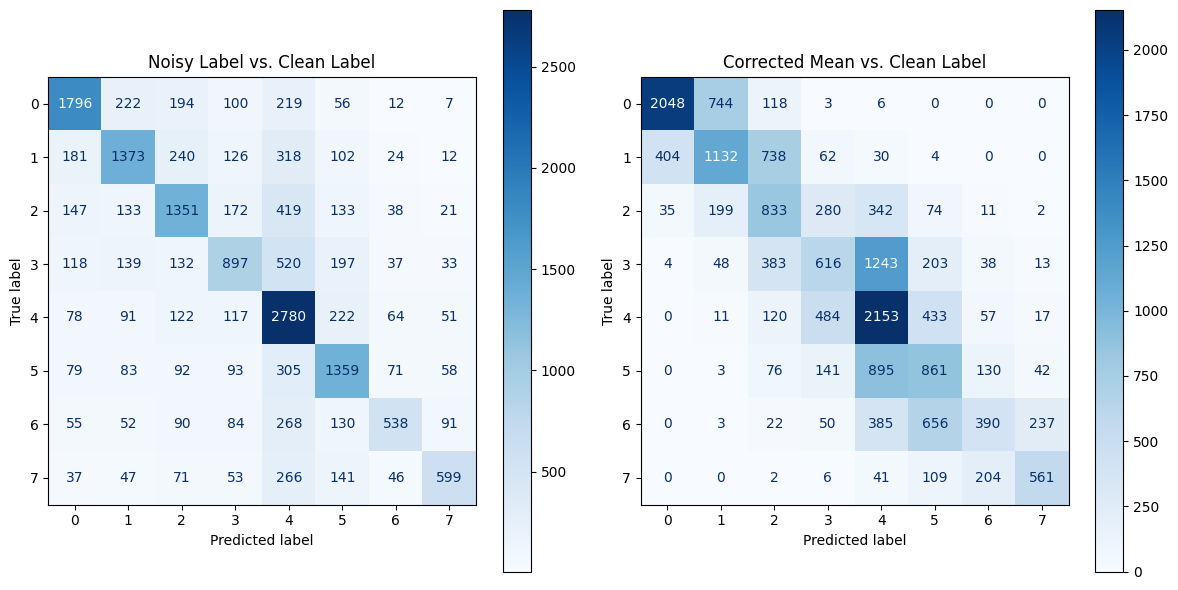

In [11]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smed_carl_v2

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6940
  RMSE: 1.0430


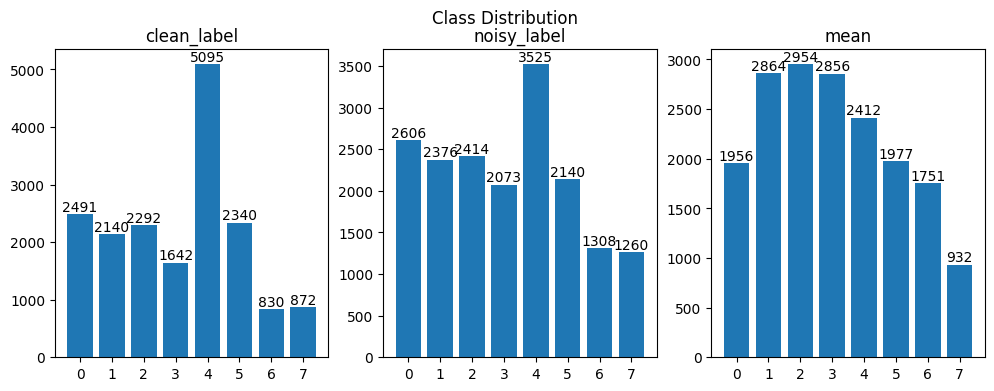

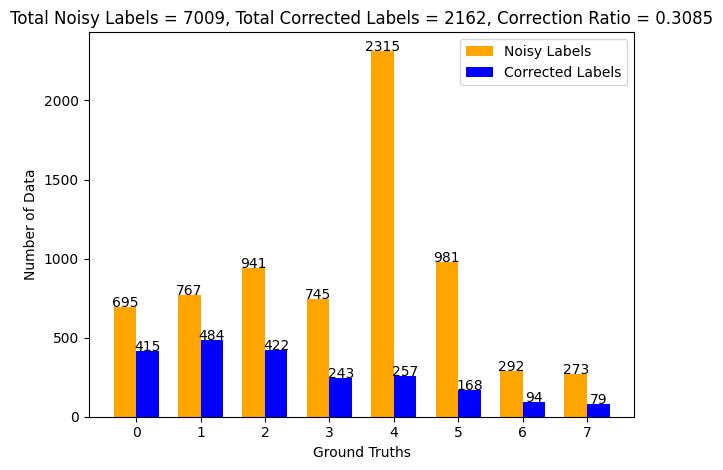

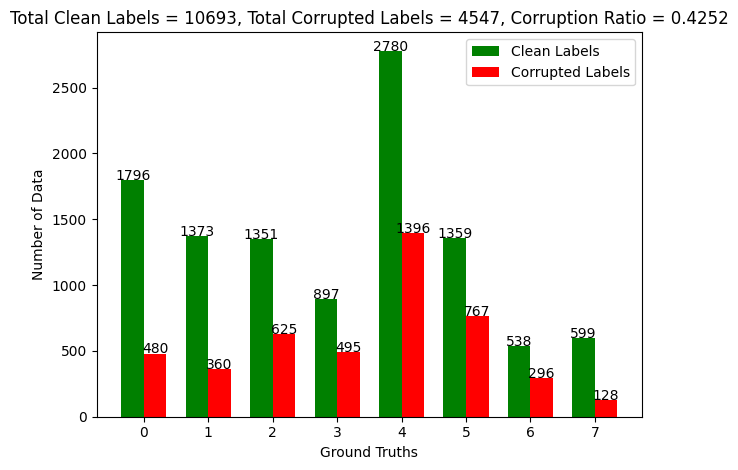

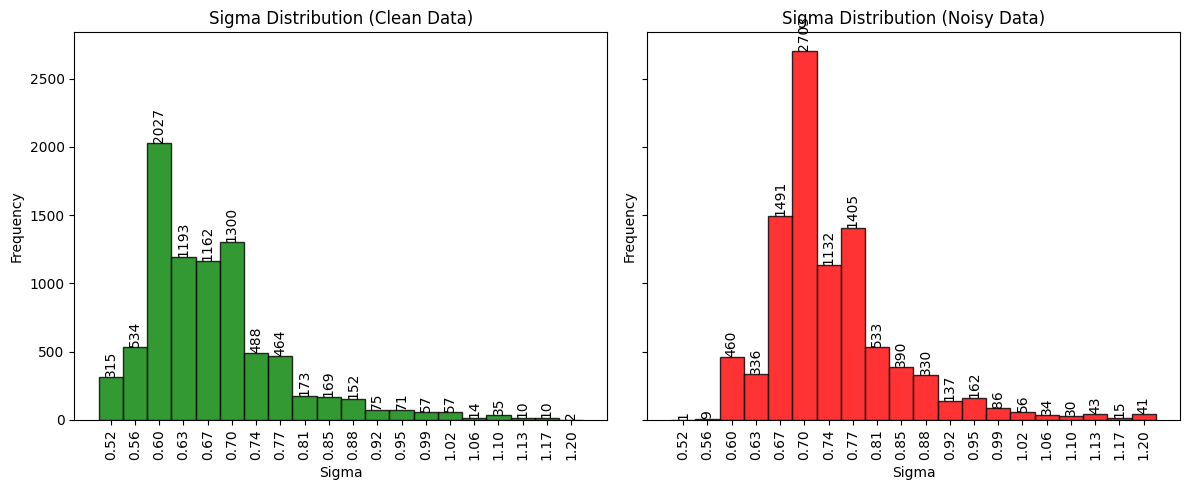

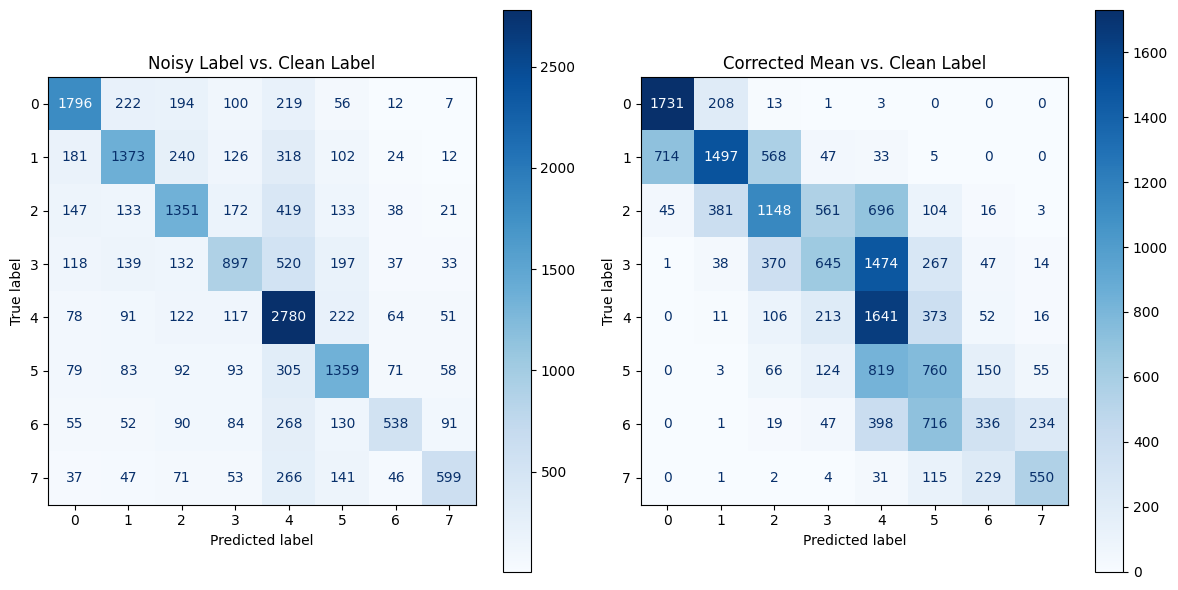

In [10]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smed_carl_v2',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3

Metrics between clean_label and noisy_label:
Overal MAE: 0.0000, Overal RMSE: 0.0000
Class-wise MAE: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
Class-wise RMSE: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
Average MAE across classes: 0.0
Average RMSE across classes: 0.0

Metrics between clean_label and rounded mean:
Overal MAE: 0.3871, Overal RMSE: 0.6968
Class-wise MAE: {0: 0.2067, 1: 0.2645, 2: 0.5323, 3: 0.5402, 4: 0.3001, 5: 0.5778, 6: 0.6145, 7: 0.3131}
Class-wise RMSE: {0: 0.492, 1: 0.5645, 2: 0.8355, 3: 0.7808, 4: 0.6188, 5: 0.8603, 6: 0.8849, 7: 0.6558}
Average MAE across classes: 0.4186
Average RMSE across classes: 0.7116


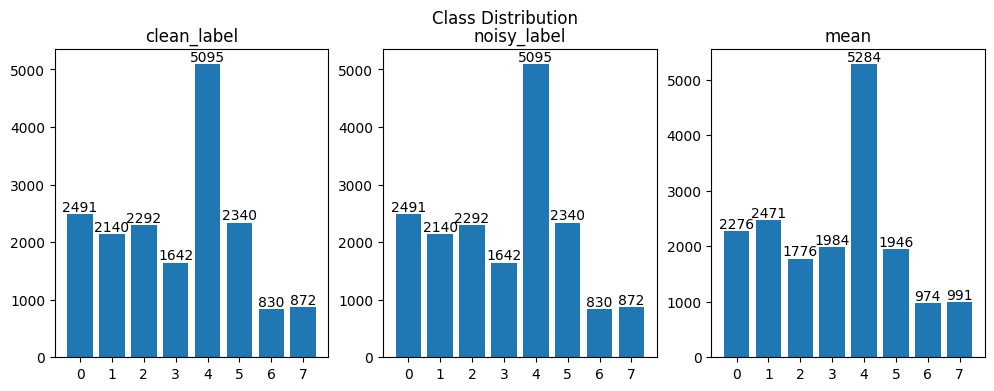

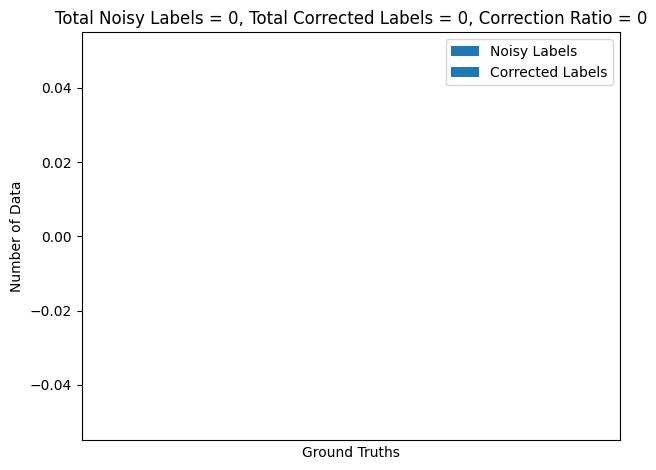

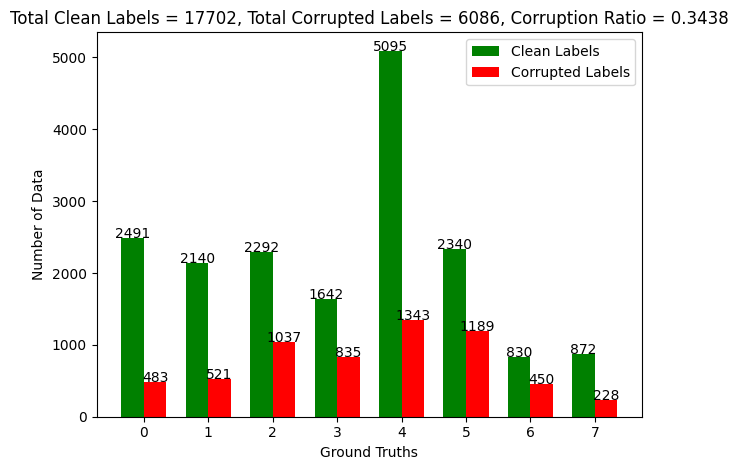

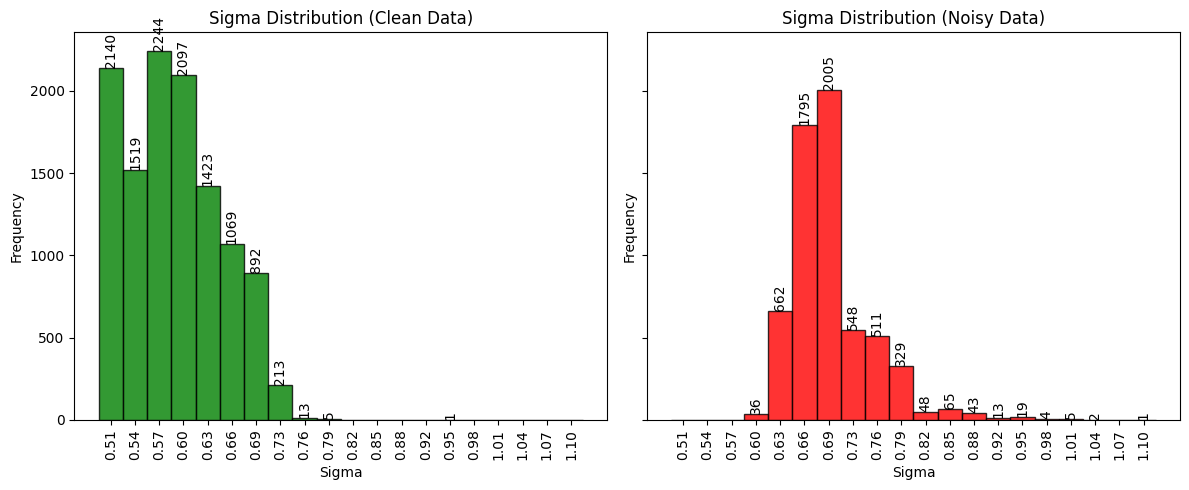

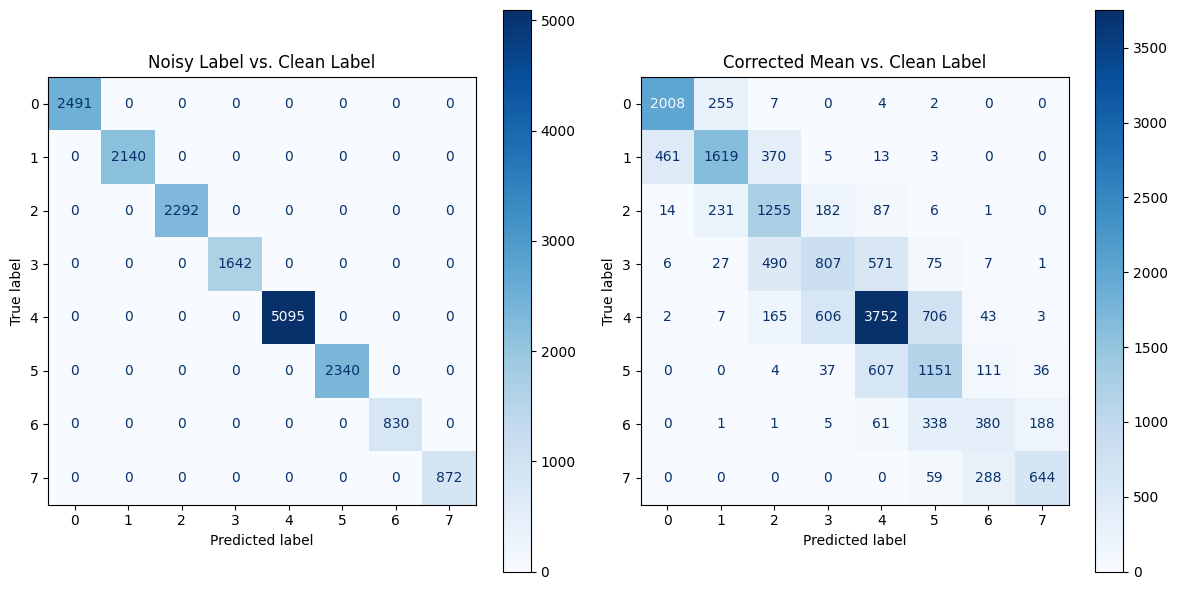

In [30]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3_noisy_test

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.6599
  RMSE: 1.0081


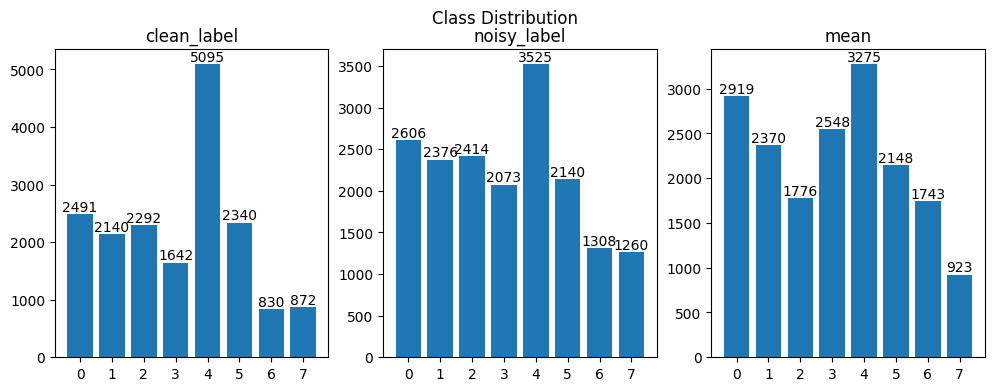

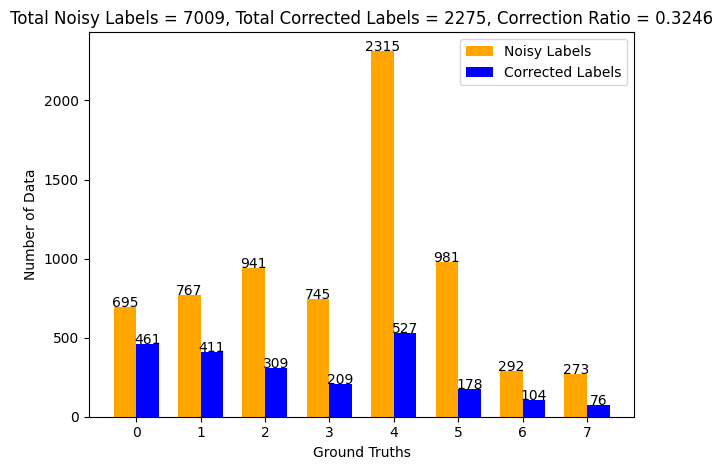

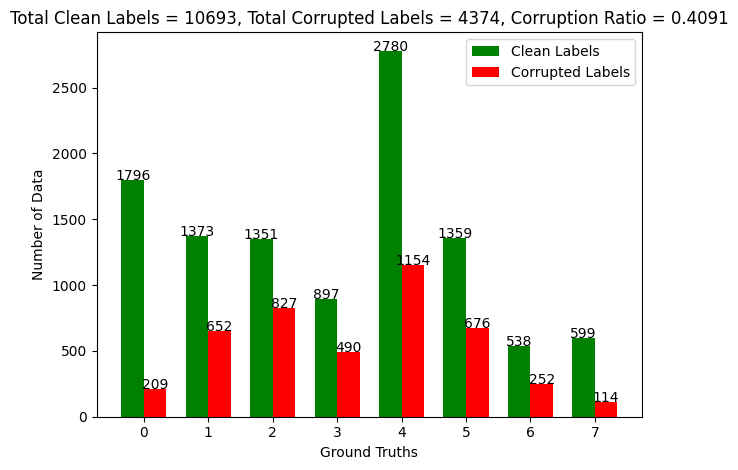

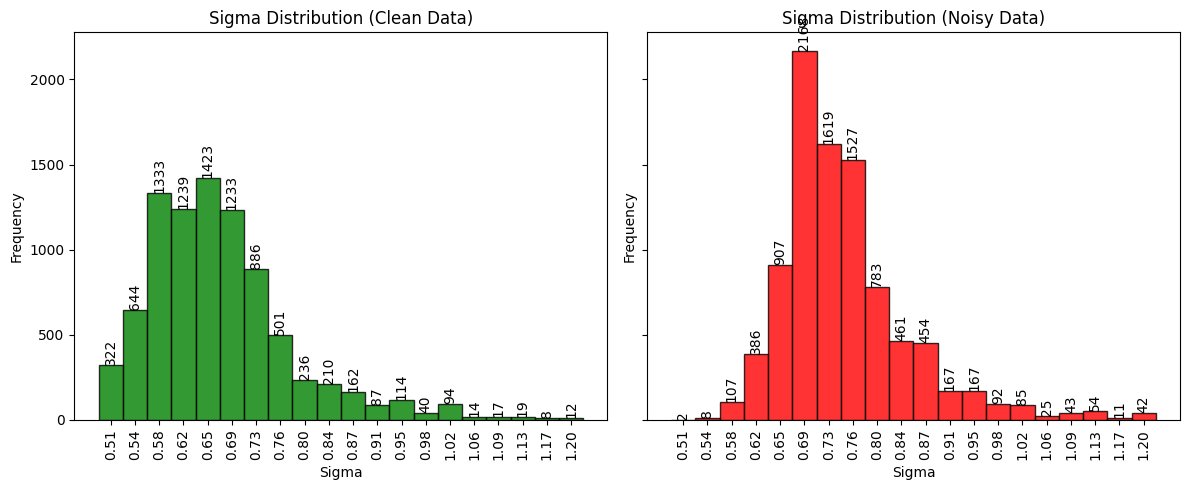

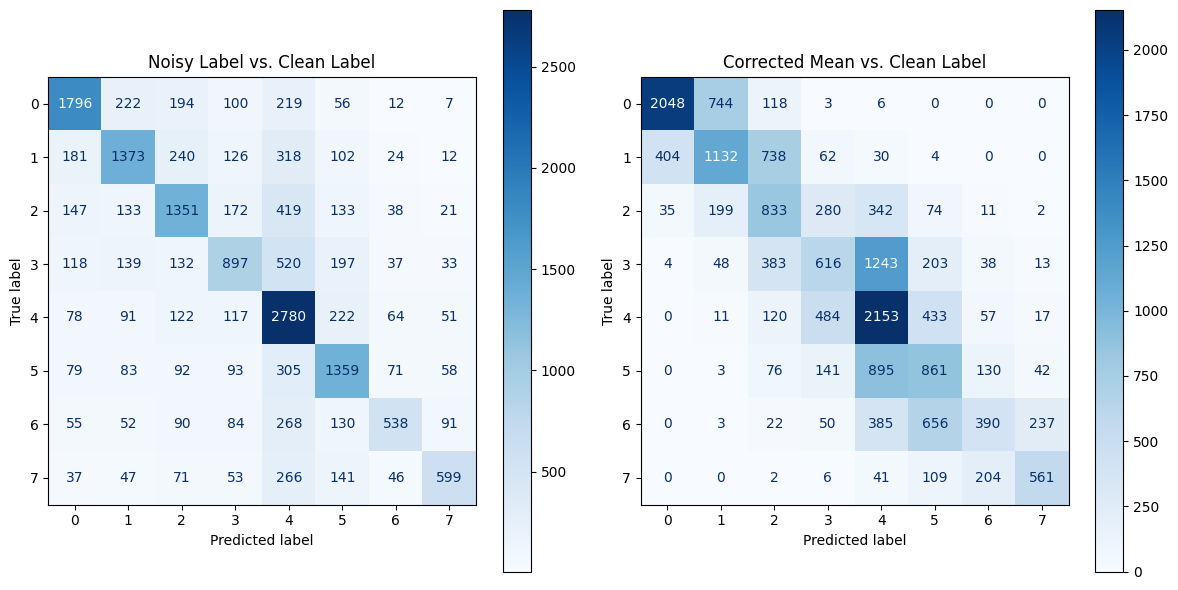

In [10]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3_noisy_test',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_dldl_v2_noisy_test

Metrics between clean_label and noisy_label:
  MAE: 0.8898
  RMSE: 1.6375

Metrics between clean_label and rounded mean:
  MAE: 0.8898
  RMSE: 1.6375


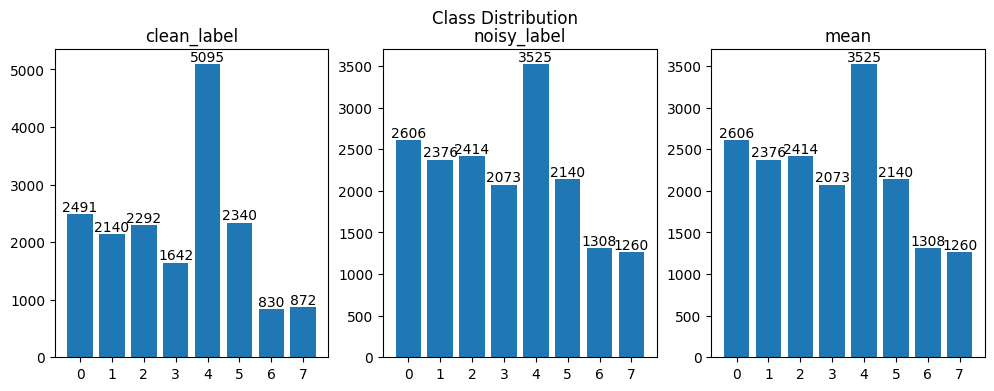

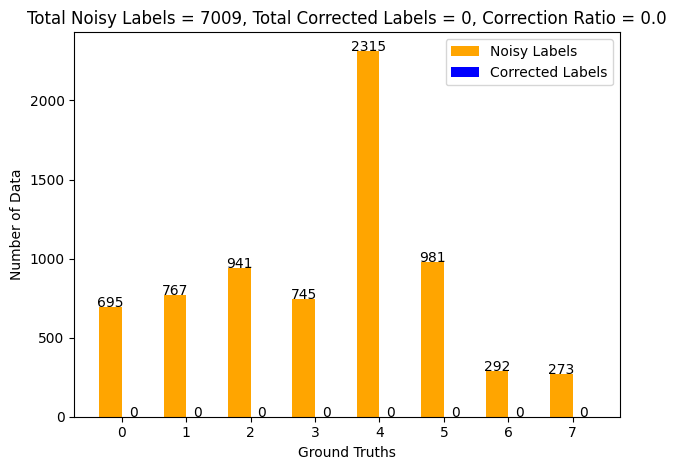

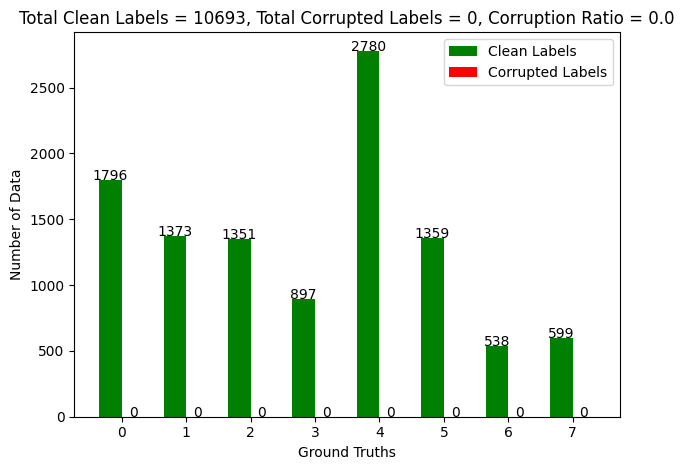

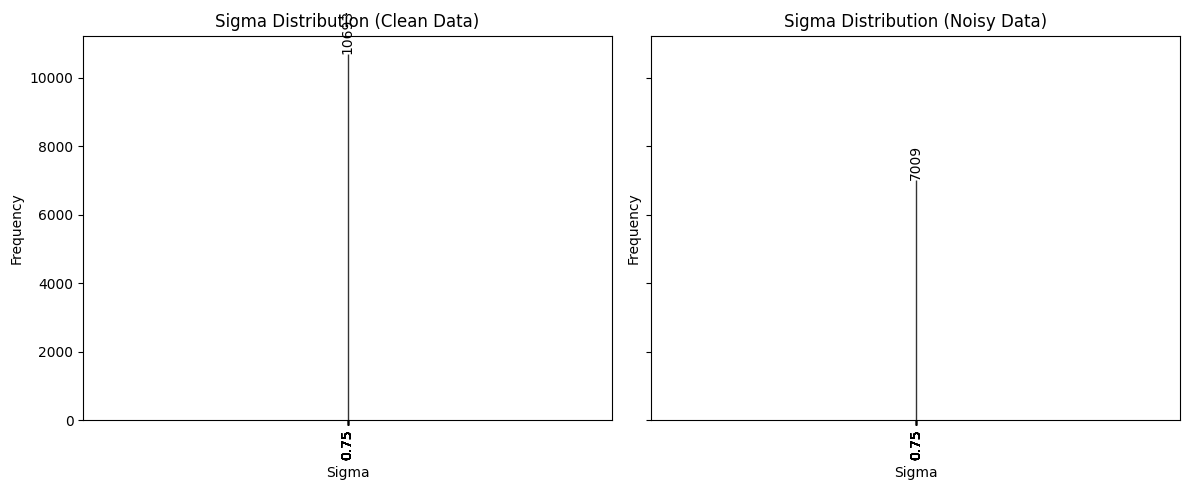

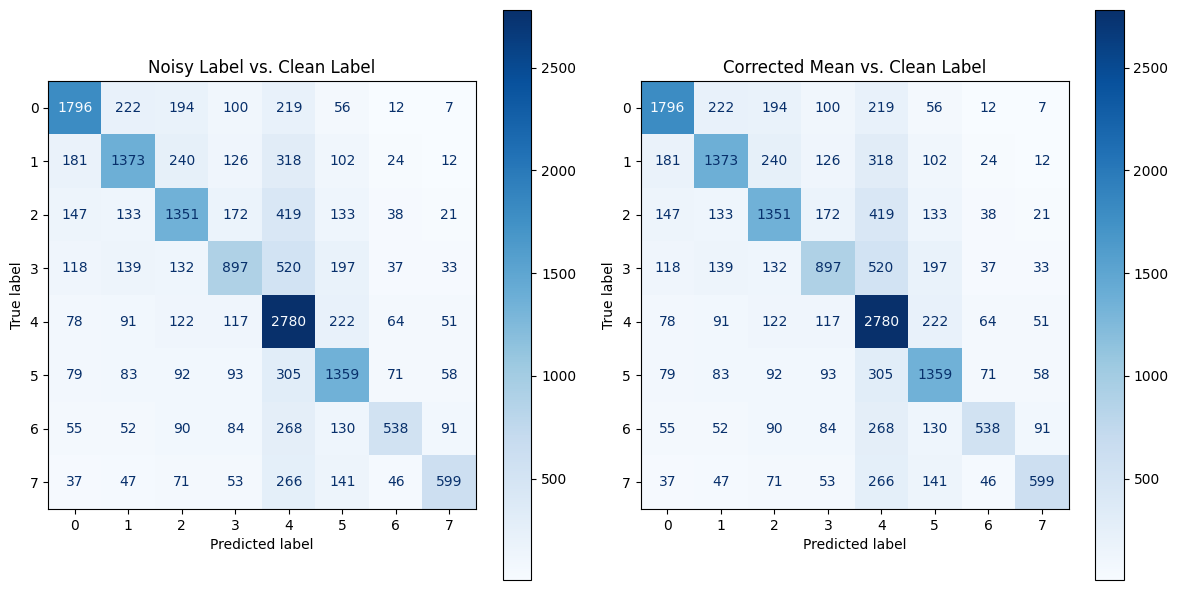

In [11]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_noisy_test',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_nr2_smcarl_v3

Metrics between clean_label and noisy_label:
MAE : {0: 0.4171, 1: 0.4009, 2: 0.4468, 3: 0.4744, 4: 0.4703, 5: 0.4551, 6: 0.3639, 7: 0.3463}
RMSE: {0: 1.2746, 1: 1.1365, 2: 1.1131, 3: 1.0884, 4: 1.085, 5: 1.1207, 6: 1.0585, 7: 1.0942}
overal MAE: 0.4387, overal RMSE: 1.1276
class MAE : 0.4218, class RMSE : 1.1214

Metrics between clean_label and rounded mean:
MAE : {0: 0.2449, 1: 0.2729, 2: 0.5554, 3: 0.5974, 4: 0.56, 5: 0.6991, 6: 0.6145, 7: 0.4025}
RMSE: {0: 0.5225, 1: 0.5752, 2: 0.8972, 3: 0.9263, 4: 0.8948, 5: 0.9674, 6: 0.8971, 7: 0.7759}
overal MAE: 0.4970, overal RMSE: 0.8269
class MAE : 0.4933, class RMSE : 0.8070


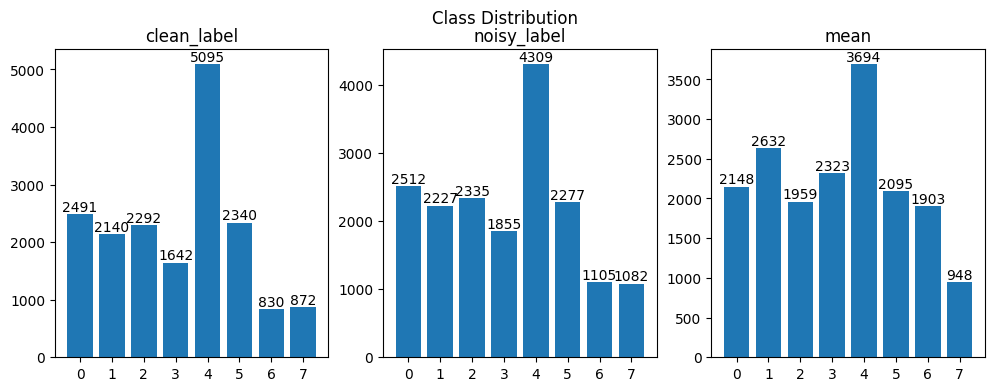

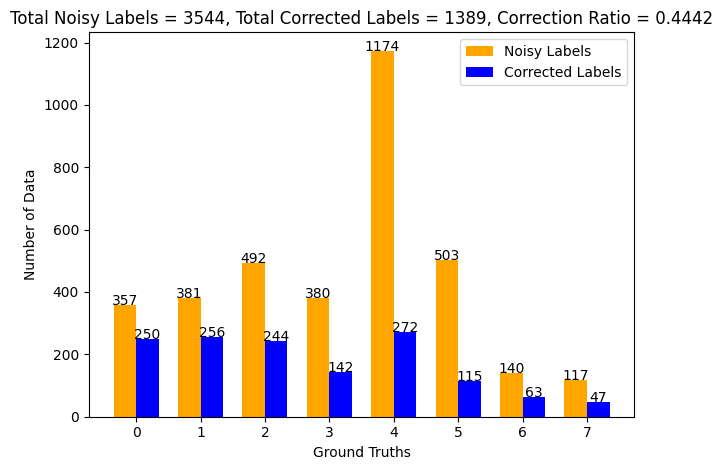

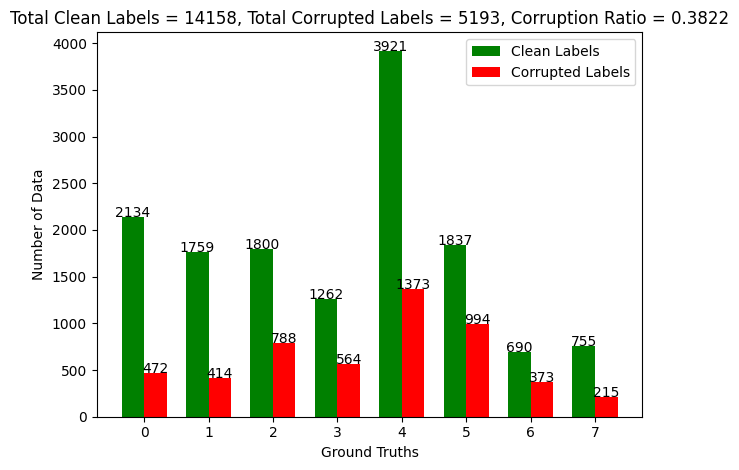

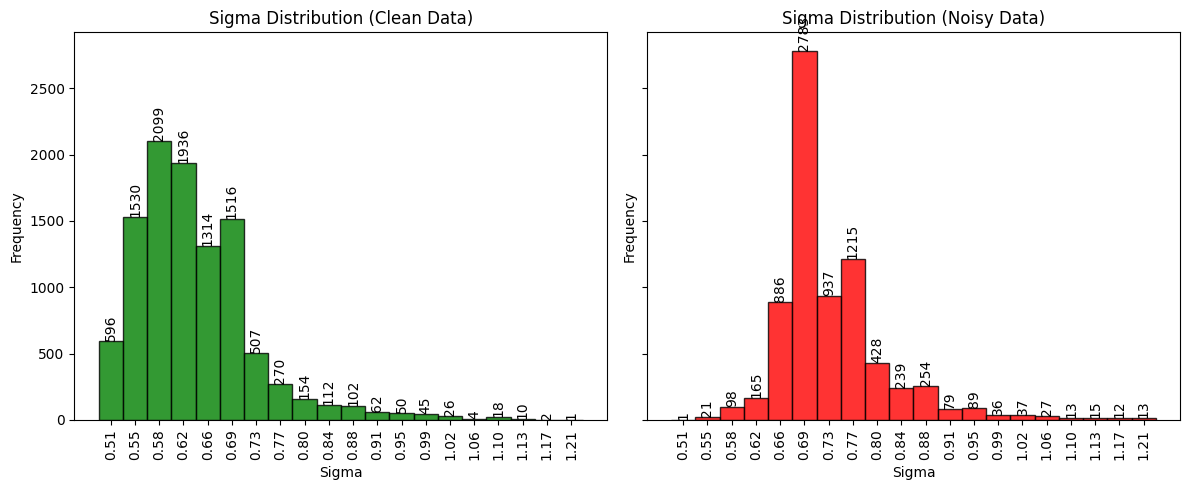

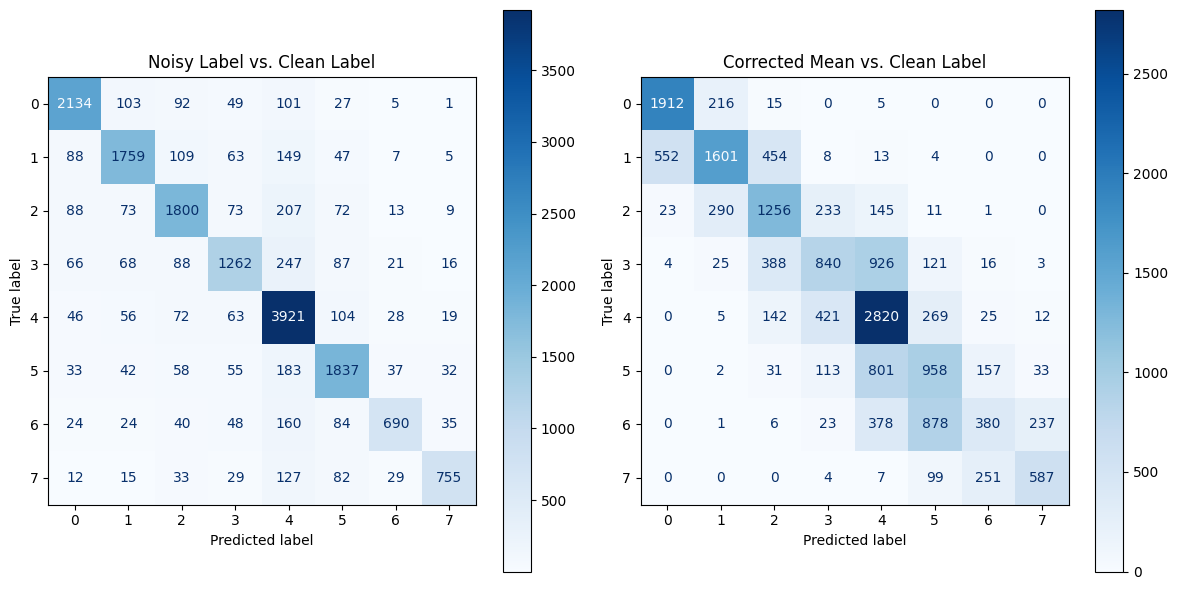

In [13]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_nr2_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3

Metrics between clean_label and noisy_label:
MAE : {0: 0.8531, 1: 0.8318, 2: 0.8704, 3: 0.908, 4: 0.9474, 5: 0.9038, 6: 0.8434, 7: 0.8234}
RMSE: {0: 1.8846, 1: 1.6814, 2: 1.5741, 3: 1.4948, 4: 1.5558, 5: 1.5923, 6: 1.6812, 7: 1.7301}
overal MAE: 0.8898, overal RMSE: 1.6375
class MAE : 0.8727, class RMSE : 1.6493

Metrics between clean_label and rounded mean:
MAE : {0: 0.1951, 1: 0.5136, 2: 0.839, 3: 0.824, 4: 0.7515, 5: 0.8338, 6: 0.7301, 7: 0.4977}
RMSE: {0: 0.4825, 1: 0.7963, 2: 1.174, 3: 1.144, 4: 1.0652, 5: 1.1449, 6: 1.1407, 7: 0.9674}
overal MAE: 0.6599, overal RMSE: 1.0081
class MAE : 0.6481, class RMSE : 0.9894


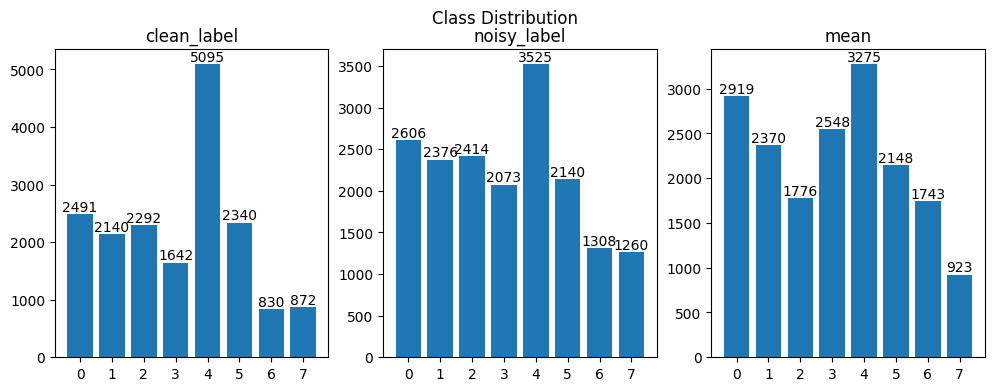

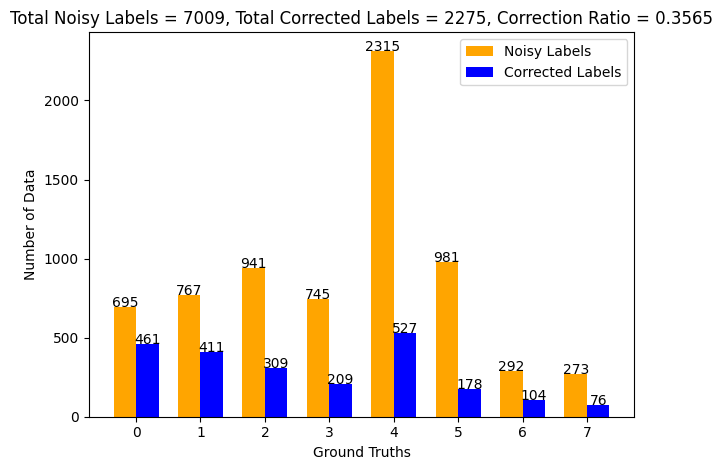

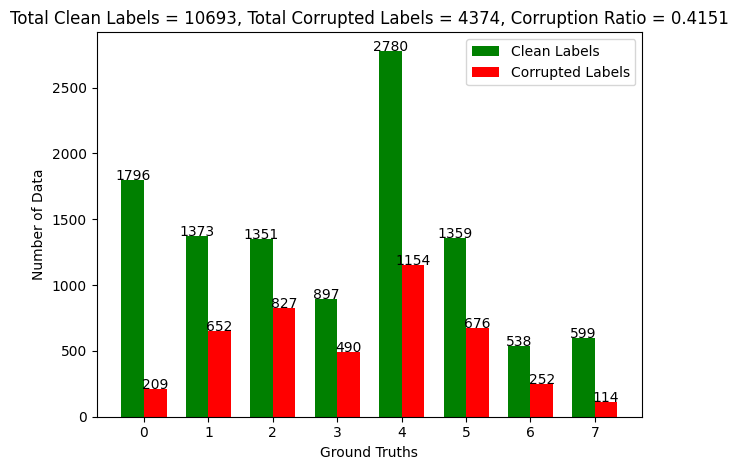

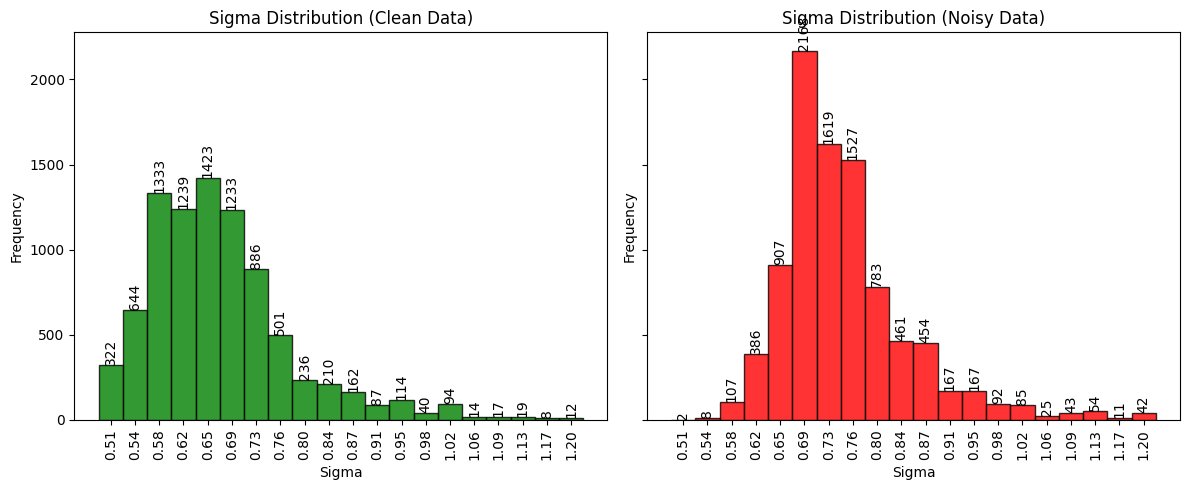

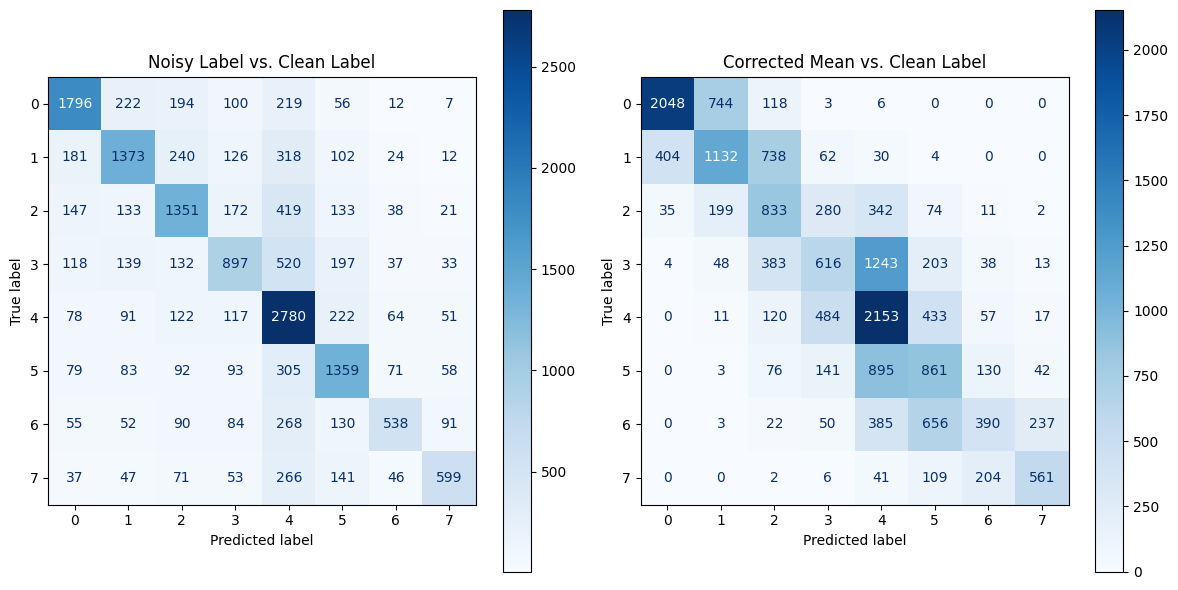

In [11]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3

Metrics between clean_label and noisy_label:
MAE : {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
RMSE: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
overal MAE: 0.0000, overal RMSE: 0.0000
class MAE : 0.0000, class RMSE : 0.0000

Metrics between clean_label and rounded mean:
MAE : {0: 0.2067, 1: 0.2645, 2: 0.5323, 3: 0.5402, 4: 0.3001, 5: 0.5778, 6: 0.6145, 7: 0.3131}
RMSE: {0: 0.492, 1: 0.5645, 2: 0.8355, 3: 0.7808, 4: 0.6188, 5: 0.8603, 6: 0.8849, 7: 0.6558}
overal MAE: 0.3871, overal RMSE: 0.6968
class MAE : 0.4186, class RMSE : 0.7116


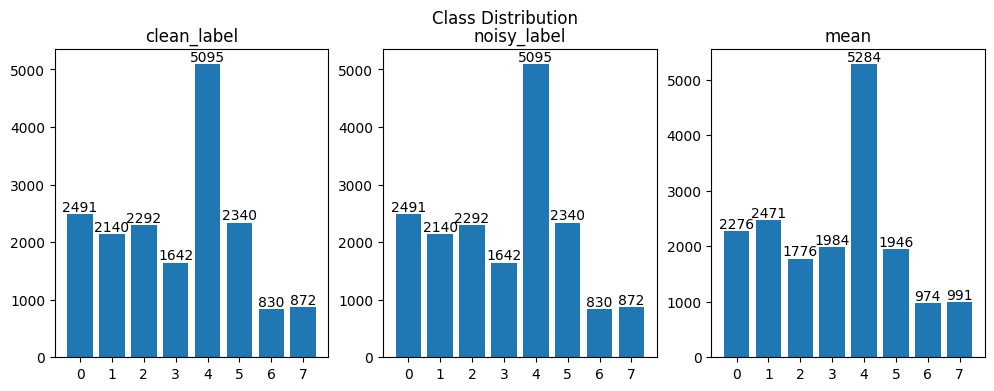

/home/vision/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vision/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


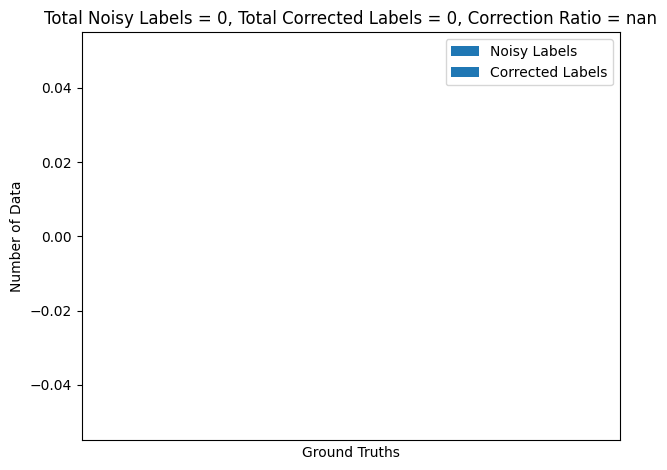

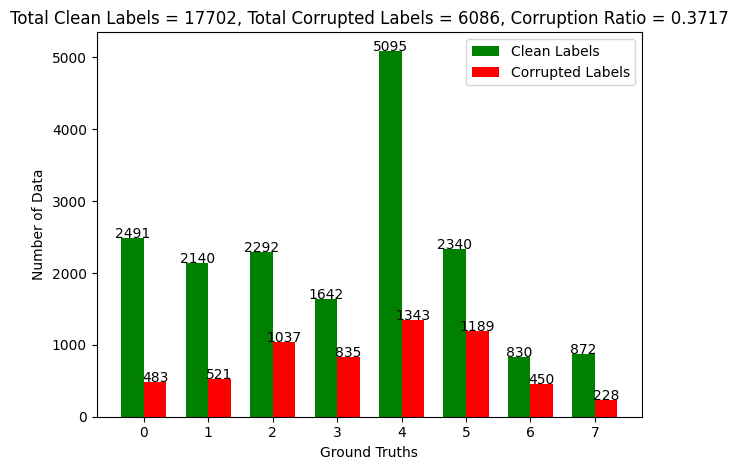

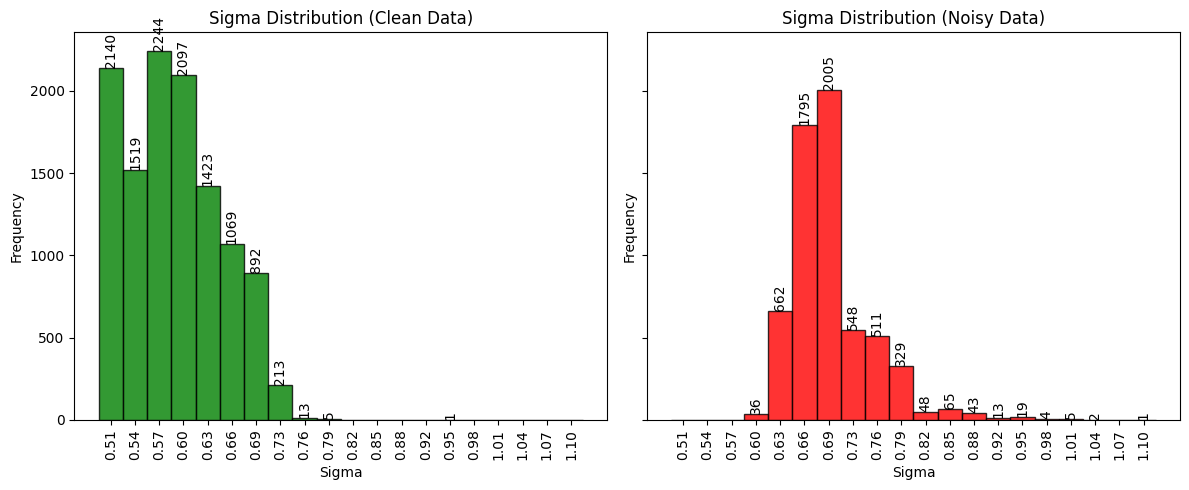

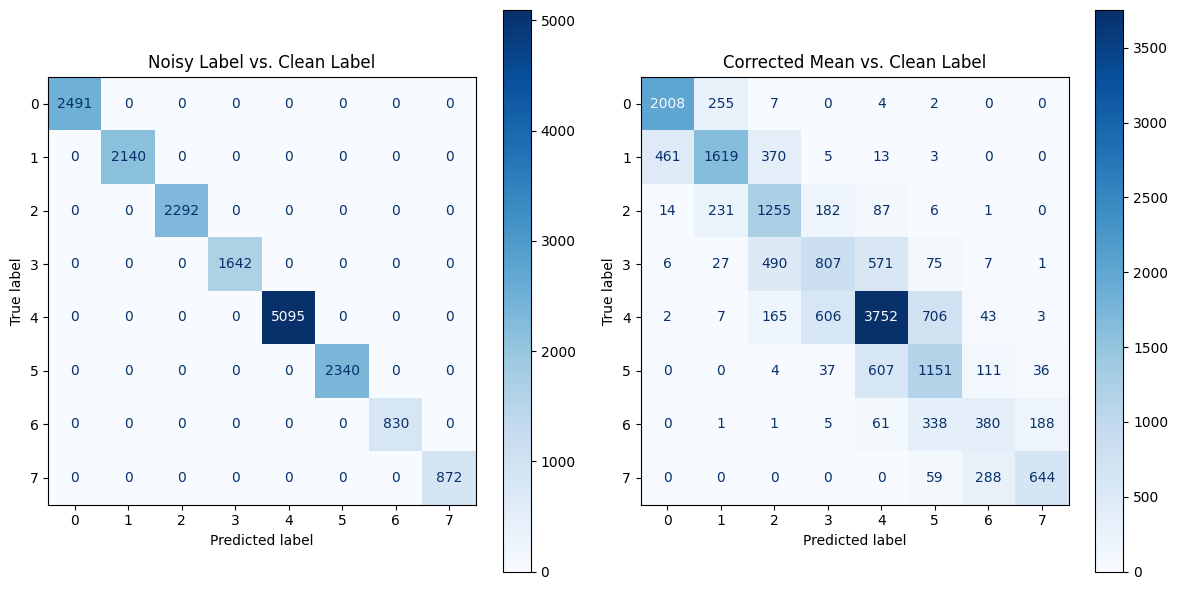

In [10]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_nr2_smcarl_v3

Metrics between clean_label and noisy_label:
MAE : {0: 0.4171, 1: 0.4009, 2: 0.4468, 3: 0.4744, 4: 0.4703, 5: 0.4551, 6: 0.3639, 7: 0.3463}
RMSE: {0: 1.2746, 1: 1.1365, 2: 1.1131, 3: 1.0884, 4: 1.085, 5: 1.1207, 6: 1.0585, 7: 1.0942}
overal MAE: 0.4387, overal RMSE: 1.1276
class MAE : 0.4218, class RMSE : 1.1214

Metrics between clean_label and rounded mean:
MAE : {0: 0.2449, 1: 0.2729, 2: 0.5554, 3: 0.5974, 4: 0.56, 5: 0.6991, 6: 0.6145, 7: 0.4025}
RMSE: {0: 0.5225, 1: 0.5752, 2: 0.8972, 3: 0.9263, 4: 0.8948, 5: 0.9674, 6: 0.8971, 7: 0.7759}
overal MAE: 0.4970, overal RMSE: 0.8269
class MAE : 0.4933, class RMSE : 0.8070


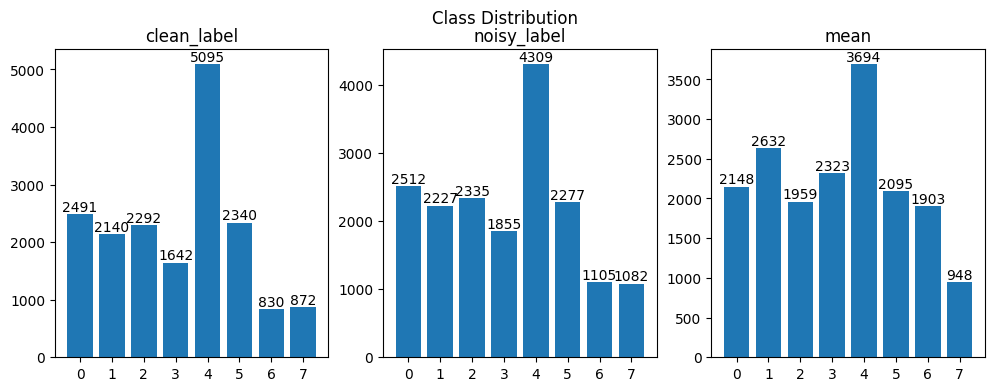

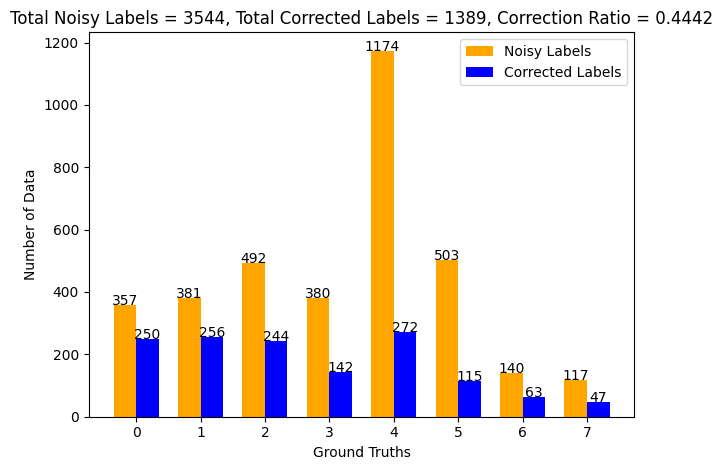

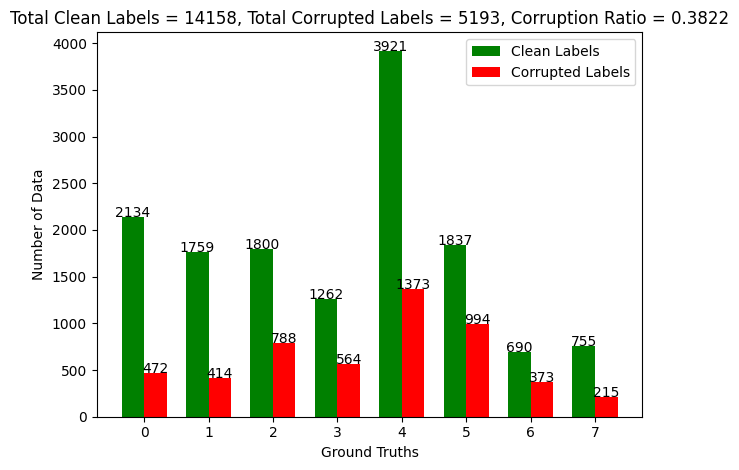

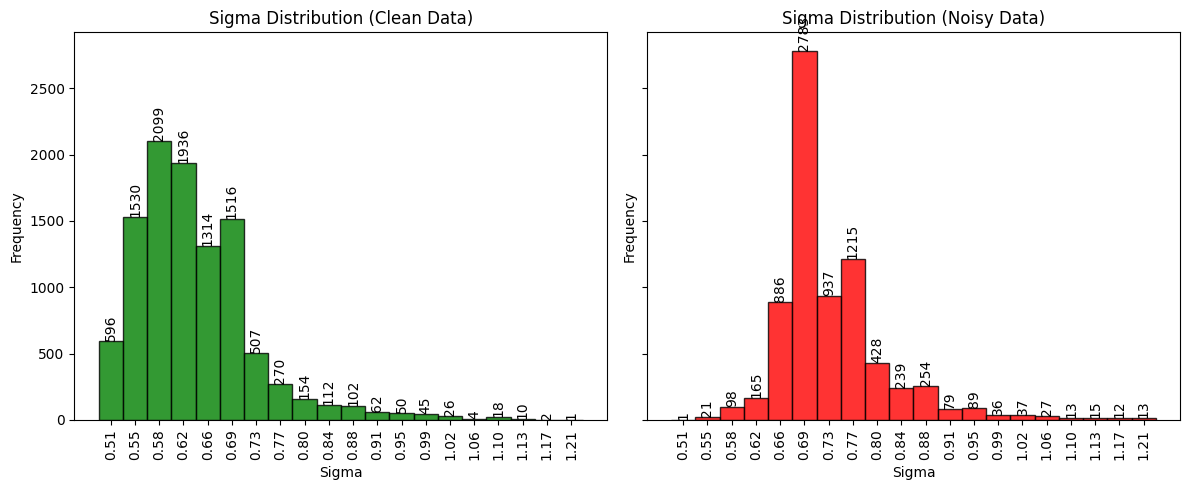

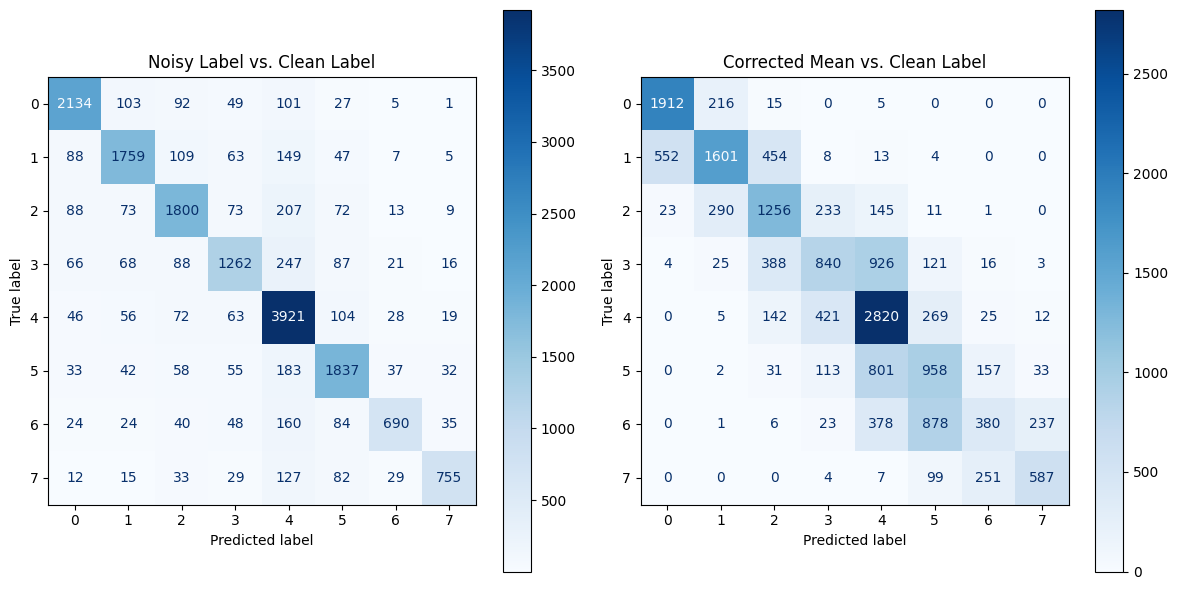

In [12]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_nr2_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

print_correction_metrics(df)
class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)